In [2]:
!pip install tsai optuna-integration

print("done")

done


In [2]:
import pandas as pd  # For dataset loading and manipulation
import numpy as np  # For arrays operation
from collections import Counter  # To count labels inside of lists

In [3]:
# Load the hr dataset, change its path.
df = pd.read_pickle("/kaggle/input/hr-pickle/hr.pickle")

In [4]:
# Create query lists that we will use to get the faults we want from the dataframe.
###### Change the names in faults_to_take if you want to include/exclude faults or experiment with other faults ######
faults_to_take = ["BearingFault", "BearingWear", "BearingLubrication", "Flow"]
locations = ["machine", "motor"]
query_strings = []
for fault in faults_to_take:
    for location in locations:
        query_strings.append([fault, location])
query_strings

[['BearingFault', 'machine'],
 ['BearingFault', 'motor'],
 ['BearingWear', 'machine'],
 ['BearingWear', 'motor'],
 ['BearingLubrication', 'machine'],
 ['BearingLubrication', 'motor'],
 ['Flow', 'machine'],
 ['Flow', 'motor']]

In [5]:
# The following are dataframe preprocessing steps to create the arrays we will use in the training.
df["motor_bearing"] = 0
df["machine_bearing"] = 0

for index, row in df.iterrows():
    faults = row["faults"]

    for query in query_strings:
        if query in faults:
            if "motor" in query:
                df.at[index, "motor_bearing"] = 1

            elif "machine" in query:
                df.at[index, "machine_bearing"] = 1

In [6]:
# ts_list contains the actual time series values, labels_list is a list of lists, each sublist has two values [motor_label, machine_label]
ts_list = df["ts"].to_list()
labels_list = df.apply(
    lambda row: [row["motor_bearing"], row["machine_bearing"]], axis=1
)

In [7]:
# Separate each channel with its own label!
# First six channels which are the motor ones, will take the first element in each sublist of labels_list and vice versa with the other channels which are the machine's
ts_exploded = []
labels_exploded = []

for ts, label in zip(ts_list, labels_list):
    for i in range(len(ts)):
        ts_exploded.append(ts[i])
        if i < 6:
            labels_exploded.append(label[0])
        else:
            labels_exploded.append(label[1])

In [8]:
# Rename the lists for more clarity
ts_list = ts_exploded
labels_list = labels_exploded

In [9]:
# FFT and Sliding window functions.


# Note: DON'T USE FFT
def GetFFT(ts):
    return np.abs(np.fft.rfft(ts * np.hanning(len(ts))))[:-1] * 2


def slide_ts(time_series, label, window_length=1024, overlap=0, fft=False):

    time_series = time_series[~np.isnan(time_series)]

    windowed_ts_list = []
    windowed_labels = []

    step_size = int(window_length * (1 - overlap))

    for i in range(0, len(time_series) - window_length + 1, step_size):
        start = i
        end = i + window_length
        if fft == True:
            windowed_ts_list.append(GetFFT(time_series[start:end]))
        else:
            windowed_ts_list.append(time_series[start:end])

        windowed_labels.append(label)

    return (np.array(windowed_ts_list), np.array(windowed_labels))

In [10]:
# Import tsai
from tsai.all import *

computer_setup()

os              : Linux-5.15.133+-x86_64-with-glibc2.31
python          : 3.10.13
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.1.2
device          : 1 gpu (['Tesla P100-PCIE-16GB'])
cpu cores       : 2
threads per cpu : 2
RAM             : 31.36 GB
GPU memory      : [16.0] GB


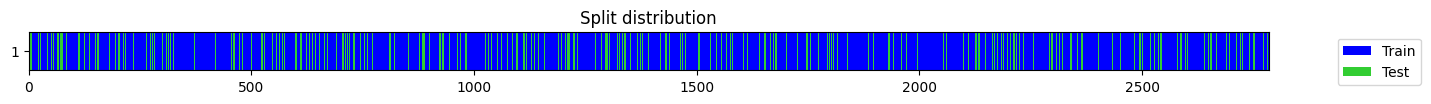

((#2228) [844,1596,440,503,2365,2192,1929,2563,2112,1066...],
 (#556) [723,1080,633,620,30,154,1566,1418,2542,1676...])

In [11]:
# Shuffle and do training and testing splitting.
# REMEMBER! Make sure to NOT include two windows of the same time series in training and testing simultaneously.
splits = get_splits(
    np.array(labels_list), valid_size=0.2, random_state=23, shuffle=True
)
splits

In [12]:
train_sample_indices = list(splits[0])
test_sample_indices = list(splits[1])

In [13]:
# Now that we made each time series in its container (train, test), we can now apply the sliding window safely.

window_length = 1024 // 4
overlap = 0.2


fft = False  # Always make it False... for now.

X_train = []
y_train = []
X_test = []
y_test = []

for index in train_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = slide_ts(
        ts, label=label, window_length=window_length, overlap=overlap, fft=fft
    )
    X_train.append(data_pairs[0])
    y_train.append(data_pairs[1])

# Iterate over the test samples
for index in test_sample_indices:
    ts = ts_list[index]
    label = labels_list[index]
    data_pairs = slide_ts(
        ts, label=label, window_length=window_length, overlap=overlap, fft=fft
    )
    X_test.append(data_pairs[0])
    y_test.append(data_pairs[1])

# Concatenate the train and test sets
X_train_arr = np.concatenate(X_train, axis=0)
y_train_arr = np.concatenate(y_train, axis=0)
X_test_arr = np.concatenate(X_test, axis=0)
y_test_arr = np.concatenate(y_test, axis=0)

In [14]:
# See how they got unbalanced again after applying windowing?
# Let's apply undersampling on them, the following undersampling library not just removes samples randomly, but remove them in an intelligent way, and to not remove important samples.
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=5)

In [15]:
# Now, apply the fit_resample method
X_train_arr, y_train_arr = undersample.fit_resample(X_train_arr, y_train_arr)

In [16]:
X, y, splits = combine_split_data([X_train_arr, X_test_arr], [y_train_arr, y_test_arr])

In [17]:
tfms = [None, [TSStandardize(by_var=True), Categorize()]]
batch_tfms = [TSStandardize(by_sample=True)]
dls = get_ts_dls(
    X,
    y,
    splits=splits,
    tfms=tfms,
    shuffle_train=True,
    batch_tfms=batch_tfms,
    bs=[64, 256],
)

##### TASK 1 #####
Callbacks: Stop the training of the model based on a given criteria.
Example: Stop training when the {metric} starts to decrease for {x} iterations

##### TASK 3 #####
Experiment with different variations of CNN (FCN), resnet, LSTM, LSTM_FCN, InceptionTime, Transofrmers (TST)

In [18]:
from fastai.callback.all import *

In [19]:
import optuna
from optuna.integration import FastAIPruningCallback

num_epochs = 5
num_optuna_trials = 100


def objective(trial: optuna.Trial):
    # Define search space here. Supported search space are
    num_filters = trial.suggest_categorical("num_filters", [32, 64, 96, 128])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 1.0)

    model = InceptionTimePlus(dls.vars, dls.c, nf=num_filters, fc_dropout=dropout_rate)
    learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])
    learn.fit_one_cycle(num_epochs, lr_max=learn.lr_find())

    # return the valid_loss - learn.recorder.values returns [[train_loss, valid_loss, acc]]
    return learn.recorder.values[-1][1]

[I 2024-02-18 06:59:48,911] A new study created in memory with name: no-name-761016a3-0994-4907-93ff-a4251e3ba654


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.562970,0.638765,0.674434,0.637461,0.888393,0.742294,01:17
1,0.495604,0.577003,0.737286,0.757522,0.738674,0.747979,01:17
2,0.426545,0.566004,0.733642,0.722538,0.804113,0.761146,01:17
3,0.350674,0.575481,0.743662,0.781486,0.713936,0.746186,01:17
4,0.311259,0.583794,0.755427,0.773413,0.758953,0.766115,01:17


[I 2024-02-18 07:06:28,274] Trial 0 finished with value: 0.5837936997413635 and parameters: {'num_filters': 128, 'dropout_rate': 0.3804578004715309}. Best is trial 0 with value: 0.5837936997413635.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.553529,0.601664,0.738424,0.725647,0.811017,0.765960,01:17
1,0.495662,0.532643,0.748975,0.774135,0.740400,0.756892,01:17
2,0.431374,0.593347,0.717853,0.809015,0.609233,0.695053,01:17
3,0.356512,0.576318,0.744345,0.791701,0.699698,0.742862,01:17
4,0.286853,0.602283,0.757325,0.771780,0.767007,0.769386,01:17


[I 2024-02-18 07:13:05,990] Trial 1 finished with value: 0.6022826433181763 and parameters: {'num_filters': 128, 'dropout_rate': 0.36585845249234994}. Best is trial 0 with value: 0.5837936997413635.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.555492,0.598285,0.693791,0.800000,0.559758,0.658656,00:21
1,0.483839,0.582489,0.729543,0.704661,0.839350,0.766131,00:21
2,0.411876,0.603775,0.722863,0.810105,0.620308,0.702615,00:21
3,0.336911,0.583776,0.741081,0.768904,0.728319,0.748061,00:21
4,0.277129,0.597205,0.747913,0.760770,0.761973,0.761371,00:21


[I 2024-02-18 07:14:56,428] Trial 2 finished with value: 0.5972050428390503 and parameters: {'num_filters': 32, 'dropout_rate': 0.03184501330105527}. Best is trial 0 with value: 0.5837936997413635.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.565950,0.580263,0.713906,0.755949,0.676255,0.713884,00:57
1,0.523245,0.559923,0.719675,0.788598,0.640587,0.706928,00:57
2,0.447689,0.651334,0.724230,0.687274,0.876169,0.770310,00:57
3,0.386344,0.599811,0.740474,0.728590,0.810010,0.767146,00:58
4,0.341090,0.589416,0.740018,0.756098,0.749029,0.752547,00:58


[I 2024-02-18 07:19:53,440] Trial 3 finished with value: 0.5894162058830261 and parameters: {'num_filters': 96, 'dropout_rate': 0.36104257040551047}. Best is trial 0 with value: 0.5837936997413635.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.550532,0.617530,0.677091,0.799556,0.518050,0.628731,00:58
1,0.501275,0.601389,0.723622,0.713457,0.796059,0.752498,00:58
2,0.439753,0.604141,0.712464,0.761009,0.663598,0.708974,00:58
3,0.374480,0.567598,0.750569,0.768409,0.754926,0.761608,00:58
4,0.330225,0.598859,0.747305,0.770367,0.742557,0.756207,00:58


[I 2024-02-18 07:24:51,596] Trial 4 finished with value: 0.5988588929176331 and parameters: {'num_filters': 96, 'dropout_rate': 0.33009510159824007}. Best is trial 0 with value: 0.5837936997413635.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.609684,0.596650,0.678761,0.801864,0.519776,0.630716,01:17
1,0.532515,0.576944,0.728860,0.782929,0.672803,0.723700,01:17
2,0.476084,0.547366,0.737286,0.798054,0.672372,0.729842,01:17
3,0.414567,0.542238,0.753530,0.761945,0.775205,0.768518,01:17
4,0.369141,0.556850,0.745863,0.772652,0.734647,0.753170,01:17


[I 2024-02-18 07:31:30,291] Trial 5 finished with value: 0.5568495988845825 and parameters: {'num_filters': 128, 'dropout_rate': 0.887419814039693}. Best is trial 5 with value: 0.5568495988845825.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.560763,0.581859,0.738272,0.741824,0.773191,0.757183,00:58
1,0.504207,0.535270,0.738045,0.747037,0.761542,0.754220,00:58
2,0.433516,0.637174,0.732655,0.789048,0.673522,0.726723,00:58
3,0.354746,0.580925,0.744800,0.771840,0.733209,0.752028,00:58
4,0.312135,0.603943,0.743055,0.763671,0.743132,0.753262,00:58


[I 2024-02-18 07:36:28,438] Trial 6 finished with value: 0.6039425134658813 and parameters: {'num_filters': 96, 'dropout_rate': 0.3260919845747503}. Best is trial 5 with value: 0.5568495988845825.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.571071,0.568396,0.721952,0.746923,0.715662,0.730959,01:17
1,0.498250,0.627580,0.708593,0.682575,0.837193,0.752019,01:17
2,0.435665,0.575392,0.735236,0.709619,0.843521,0.770798,01:17
3,0.371985,0.575866,0.741081,0.756667,0.750899,0.753772,01:17
4,0.318362,0.607601,0.745559,0.754488,0.767726,0.761049,01:17


[I 2024-02-18 07:43:07,660] Trial 7 finished with value: 0.60760098695755 and parameters: {'num_filters': 128, 'dropout_rate': 0.4744758801112756}. Best is trial 5 with value: 0.5568495988845825.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.602525,0.789114,0.647943,0.619688,0.861930,0.721006,01:17
1,0.578426,0.546648,0.727494,0.758017,0.710485,0.733482,01:17
2,0.536868,0.572413,0.715500,0.814771,0.596577,0.688808,01:17
3,0.491788,0.565420,0.731896,0.768904,0.703437,0.734715,01:18
4,0.470270,0.557301,0.732731,0.756579,0.727743,0.741881,01:18


[I 2024-02-18 07:49:47,360] Trial 8 finished with value: 0.5573011040687561 and parameters: {'num_filters': 128, 'dropout_rate': 0.9331382288500081}. Best is trial 5 with value: 0.5568495988845825.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.564561,0.605783,0.685062,0.769927,0.575147,0.658434,01:17
1,0.497219,0.571958,0.723167,0.798483,0.635984,0.708030,01:17
2,0.430368,0.563540,0.723470,0.781176,0.661297,0.716255,01:18
3,0.357438,0.597488,0.743055,0.725709,0.824968,0.772161,01:18
4,0.313236,0.611935,0.749051,0.778780,0.732633,0.755002,01:18


[I 2024-02-18 07:56:27,056] Trial 9 finished with value: 0.6119347810745239 and parameters: {'num_filters': 128, 'dropout_rate': 0.4695079121191479}. Best is trial 5 with value: 0.5568495988845825.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.650397,0.611222,0.652877,0.644593,0.762980,0.698808,01:09
1,0.614735,0.560073,0.723470,0.747310,0.719258,0.733016,01:09
2,0.570860,0.559770,0.716487,0.819246,0.593844,0.688568,01:09
3,0.519928,0.545241,0.736602,0.781842,0.694808,0.735760,01:09
4,0.506834,0.539221,0.735540,0.790585,0.678700,0.730382,01:09


[I 2024-02-18 08:02:21,777] Trial 10 finished with value: 0.5392208099365234 and parameters: {'num_filters': 64, 'dropout_rate': 0.9812731076661749}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.633755,0.979021,0.598224,0.581055,0.855746,0.692142,01:09
1,0.599340,0.605524,0.700698,0.679295,0.820078,0.743077,01:09
2,0.572895,0.580176,0.697283,0.813094,0.553718,0.658795,01:09
3,0.529860,0.564794,0.729771,0.787494,0.668345,0.723043,01:09
4,0.509318,0.550670,0.733262,0.781378,0.686754,0.731017,01:09


[I 2024-02-18 08:08:16,563] Trial 11 finished with value: 0.5506700873374939 and parameters: {'num_filters': 64, 'dropout_rate': 0.9665223330716844}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.578657,0.657548,0.708517,0.697400,0.790882,0.741205,01:09
1,0.538893,0.549801,0.729012,0.808499,0.637567,0.712930,01:09
2,0.472826,0.556465,0.735919,0.748214,0.753056,0.750627,01:09
3,0.404320,0.555526,0.745484,0.781690,0.718395,0.748707,01:09
4,0.379347,0.561606,0.743206,0.772936,0.727024,0.749277,01:09


[I 2024-02-18 08:14:10,887] Trial 12 finished with value: 0.5616064071655273 and parameters: {'num_filters': 64, 'dropout_rate': 0.7477311522431884}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.576965,0.564494,0.719903,0.754802,0.695096,0.723720,01:09
1,0.513741,0.587418,0.720434,0.721545,0.765856,0.743041,01:09
2,0.466292,0.563412,0.753454,0.785307,0.733353,0.758441,01:09
3,0.395421,0.554304,0.742220,0.751591,0.764131,0.757809,01:09
4,0.348219,0.572580,0.747988,0.757404,0.768733,0.763026,01:09


[I 2024-02-18 08:20:05,411] Trial 13 finished with value: 0.5725796818733215 and parameters: {'num_filters': 64, 'dropout_rate': 0.7668620384291831}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.722279,0.657614,0.711174,0.727325,0.724292,0.725805,01:09
1,0.699457,0.643084,0.600349,0.576713,0.912556,0.706767,01:09
2,0.662799,0.605033,0.702292,0.784708,0.600748,0.680515,01:09
3,0.642896,0.590575,0.722408,0.805411,0.625054,0.703863,01:09
4,0.625136,0.576289,0.723167,0.797731,0.636991,0.708357,01:09


[I 2024-02-18 08:25:59,715] Trial 14 finished with value: 0.5762893557548523 and parameters: {'num_filters': 64, 'dropout_rate': 0.9949309301828516}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.596147,0.580561,0.709504,0.756819,0.662448,0.706496,01:09
1,0.542045,0.561926,0.715197,0.813762,0.597008,0.688734,01:09
2,0.494361,0.573580,0.729467,0.724586,0.786279,0.754173,01:09
3,0.432547,0.552568,0.737134,0.766656,0.721559,0.743424,01:09
4,0.402047,0.552219,0.745484,0.780025,0.721128,0.749421,01:09


[I 2024-02-18 08:31:54,711] Trial 15 finished with value: 0.5522187948226929 and parameters: {'num_filters': 64, 'dropout_rate': 0.6668667346930056}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.549069,0.555029,0.734477,0.792549,0.673091,0.727951,01:09
1,0.483969,0.643394,0.720662,0.704742,0.810154,0.753780,01:09
2,0.380474,0.570209,0.732048,0.716728,0.814037,0.762290,01:09
3,0.294550,0.574858,0.746926,0.797958,0.696965,0.744050,01:09
4,0.241945,0.566688,0.754820,0.771792,0.760247,0.765976,01:09


[I 2024-02-18 08:37:49,272] Trial 16 finished with value: 0.5666878819465637 and parameters: {'num_filters': 64, 'dropout_rate': 0.6389171905810065}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.583107,0.617472,0.715652,0.705762,0.791025,0.745965,00:22
1,0.524301,0.574871,0.720510,0.750038,0.705595,0.727138,00:21
2,0.467668,0.602504,0.735691,0.729412,0.793614,0.760160,00:21
3,0.395170,0.557284,0.739639,0.803028,0.671365,0.731318,00:21
4,0.353740,0.557578,0.751328,0.772330,0.749892,0.760946,00:21


[I 2024-02-18 08:39:41,924] Trial 17 finished with value: 0.5575783252716064 and parameters: {'num_filters': 32, 'dropout_rate': 0.8347250159773334}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.555347,0.567535,0.713527,0.772501,0.648066,0.704833,01:09
1,0.482403,0.551087,0.735767,0.777051,0.700273,0.736667,01:09
2,0.411239,0.576116,0.743358,0.761417,0.748166,0.754733,01:09
3,0.334393,0.584513,0.744800,0.748926,0.776931,0.762671,01:09
4,0.262382,0.632308,0.741460,0.750955,0.763268,0.757061,01:09


[I 2024-02-18 08:45:37,041] Trial 18 finished with value: 0.6323081254959106 and parameters: {'num_filters': 64, 'dropout_rate': 0.1422785924690123}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.666656,0.806061,0.576666,0.557200,0.963900,0.706180,01:09
1,0.641313,0.601840,0.665402,0.824204,0.465267,0.594778,01:09
2,0.600402,0.562447,0.725748,0.762827,0.697109,0.728489,01:09
3,0.547596,0.569358,0.727342,0.799715,0.644901,0.714013,01:09
4,0.532614,0.554557,0.733414,0.786607,0.679131,0.728929,01:09


[I 2024-02-18 08:51:31,457] Trial 19 finished with value: 0.554557204246521 and parameters: {'num_filters': 64, 'dropout_rate': 0.9813199703259514}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.567499,0.593143,0.697207,0.789227,0.581619,0.669703,01:09
1,0.506441,0.569265,0.716259,0.747956,0.697397,0.721792,01:09
2,0.435605,0.613806,0.706695,0.723614,0.718826,0.721212,01:09
3,0.361402,0.559547,0.749658,0.777947,0.735654,0.756209,01:09
4,0.319100,0.575976,0.750949,0.768343,0.756077,0.762160,01:08


[I 2024-02-18 08:57:25,946] Trial 20 finished with value: 0.5759763121604919 and parameters: {'num_filters': 64, 'dropout_rate': 0.6378191855248956}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.585670,0.588834,0.715804,0.693757,0.826262,0.754234,01:08
1,0.537143,0.597451,0.696296,0.770627,0.604487,0.677521,01:08
2,0.488581,0.543726,0.750038,0.775519,0.740831,0.757779,01:08
3,0.434372,0.552453,0.746850,0.771948,0.738530,0.754870,01:08
4,0.405074,0.561228,0.742220,0.767403,0.734072,0.750368,01:08


[I 2024-02-18 09:03:18,372] Trial 21 finished with value: 0.5612281560897827 and parameters: {'num_filters': 64, 'dropout_rate': 0.6494519429499935}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.578504,0.646688,0.645818,0.619701,0.851431,0.717315,01:08
1,0.506592,0.562423,0.745939,0.744574,0.789443,0.766353,01:08
2,0.446617,0.582878,0.726355,0.705702,0.825974,0.761116,01:08
3,0.360080,0.595721,0.749051,0.773511,0.741694,0.757269,01:08
4,0.322555,0.581982,0.756566,0.763952,0.779663,0.771728,01:08


[I 2024-02-18 09:09:10,967] Trial 22 finished with value: 0.5819815993309021 and parameters: {'num_filters': 64, 'dropout_rate': 0.814509772703797}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.566649,0.597617,0.715121,0.698955,0.808428,0.749717,01:08
1,0.502347,0.683547,0.707606,0.674077,0.863512,0.757125,01:08
2,0.430309,0.546297,0.752695,0.743701,0.810873,0.775836,01:08
3,0.339445,0.568499,0.750266,0.770652,0.750036,0.760204,01:08
4,0.291243,0.570703,0.758843,0.767725,0.778657,0.773152,01:08


[I 2024-02-18 09:15:04,105] Trial 23 finished with value: 0.5707032084465027 and parameters: {'num_filters': 64, 'dropout_rate': 0.6927618420259647}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.617058,0.703674,0.634583,0.608612,0.861930,0.713452,00:21
1,0.591887,0.554843,0.733187,0.760218,0.722278,0.740763,00:21
2,0.534887,0.537683,0.742979,0.780028,0.714512,0.745834,00:21
3,0.483017,0.549867,0.737361,0.786171,0.690062,0.734988,00:21
4,0.465970,0.557213,0.737058,0.755081,0.742701,0.748840,00:21


[I 2024-02-18 09:16:55,104] Trial 24 finished with value: 0.5572131276130676 and parameters: {'num_filters': 32, 'dropout_rate': 0.8948854780169239}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.562055,1.070902,0.617580,0.604474,0.796778,0.687430,01:08
1,0.478032,0.586246,0.728708,0.704268,0.837768,0.765239,01:08
2,0.389300,0.581653,0.726279,0.803886,0.636704,0.710594,01:08
3,0.293747,0.572327,0.751936,0.774222,0.748166,0.760971,01:08
4,0.233221,0.582977,0.756794,0.782602,0.746584,0.764169,01:08


[I 2024-02-18 09:22:47,608] Trial 25 finished with value: 0.5829766392707825 and parameters: {'num_filters': 64, 'dropout_rate': 0.576786353877461}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.582148,0.584743,0.708213,0.767510,0.641450,0.698840,01:08
1,0.530366,0.558827,0.715880,0.813232,0.599310,0.690072,01:08
2,0.469791,0.560008,0.724457,0.733915,0.749748,0.741747,01:08
3,0.408748,0.547322,0.749203,0.779531,0.731770,0.754896,01:08
4,0.379299,0.564421,0.745559,0.762272,0.752625,0.757418,01:08


[I 2024-02-18 09:28:38,938] Trial 26 finished with value: 0.5644212365150452 and parameters: {'num_filters': 64, 'dropout_rate': 0.8414853386898462}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.583263,0.593518,0.693563,0.817786,0.539623,0.650204,01:08
1,0.545016,0.605286,0.698649,0.815661,0.554293,0.660045,01:08
2,0.473062,0.645213,0.695461,0.810822,0.551704,0.656624,01:08
3,0.411018,0.567828,0.742675,0.798059,0.686035,0.737819,01:08
4,0.387403,0.568190,0.750645,0.762300,0.766576,0.764432,01:08


[I 2024-02-18 09:34:30,495] Trial 27 finished with value: 0.5681900382041931 and parameters: {'num_filters': 64, 'dropout_rate': 0.7496327493788159}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.556956,0.604358,0.693867,0.675312,0.808859,0.736077,01:08
1,0.477137,0.552995,0.730530,0.795965,0.658133,0.720516,01:09
2,0.387984,0.562576,0.741840,0.769827,0.728750,0.748726,01:08
3,0.287607,0.583878,0.753757,0.761234,0.777218,0.769143,01:08
4,0.226906,0.609889,0.751632,0.774825,0.746297,0.760293,01:09


[I 2024-02-18 09:40:23,679] Trial 28 finished with value: 0.6098893284797668 and parameters: {'num_filters': 64, 'dropout_rate': 0.5396664479980293}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.634632,0.626141,0.641567,0.829932,0.403567,0.543062,00:58
1,0.583022,0.575210,0.718081,0.712226,0.781677,0.745337,00:58
2,0.538577,0.579081,0.701230,0.814993,0.561340,0.664793,00:58
3,0.501117,0.556324,0.740777,0.751923,0.759384,0.755635,00:58
4,0.473519,0.551229,0.740322,0.787061,0.696390,0.738955,00:58


[I 2024-02-18 09:45:21,516] Trial 29 finished with value: 0.5512292981147766 and parameters: {'num_filters': 96, 'dropout_rate': 0.9501424044639418}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.605945,0.814247,0.590405,0.593626,0.709909,0.646581,00:58
1,0.558681,0.577830,0.705405,0.800469,0.588523,0.678326,00:58
2,0.509598,0.549165,0.725900,0.779993,0.669495,0.720532,00:58
3,0.434525,0.559478,0.733642,0.795065,0.667338,0.725624,00:58
4,0.409594,0.550628,0.746394,0.756899,0.765281,0.761067,00:58


[I 2024-02-18 09:50:20,787] Trial 30 finished with value: 0.5506283640861511 and parameters: {'num_filters': 96, 'dropout_rate': 0.9379818214960663}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.612857,0.629356,0.709428,0.684671,0.833166,0.751654,00:58
1,0.568981,0.554662,0.727342,0.795811,0.650223,0.715688,00:58
2,0.527499,0.573684,0.712768,0.778814,0.636560,0.700538,00:58
3,0.483148,0.589089,0.735843,0.746417,0.756508,0.751429,00:58
4,0.455889,0.558692,0.741309,0.769418,0.728031,0.748153,00:58


[I 2024-02-18 09:55:20,876] Trial 31 finished with value: 0.558691680431366 and parameters: {'num_filters': 96, 'dropout_rate': 0.9390399818683349}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.723888,0.702997,0.579930,0.578285,0.753775,0.654471,00:58
1,0.685861,0.611683,0.692500,0.755638,0.616856,0.679230,00:58
2,0.638315,0.590398,0.701989,0.704334,0.750324,0.726602,00:58
3,0.615650,0.560410,0.723926,0.781685,0.661729,0.716722,00:58
4,0.606135,0.566645,0.717626,0.793003,0.629225,0.701684,00:58


[I 2024-02-18 10:00:20,596] Trial 32 finished with value: 0.5666449666023254 and parameters: {'num_filters': 96, 'dropout_rate': 0.9936425439438873}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.599774,0.723596,0.626993,0.821710,0.374515,0.514523,00:58
1,0.554301,0.586117,0.694474,0.816746,0.542931,0.652268,00:58
2,0.522019,0.564075,0.721876,0.732110,0.746009,0.738994,00:58
3,0.463985,0.563829,0.723622,0.781346,0.661441,0.716411,00:58
4,0.462611,0.544935,0.745787,0.771304,0.736804,0.753659,00:58


[I 2024-02-18 10:05:20,584] Trial 33 finished with value: 0.5449349880218506 and parameters: {'num_filters': 96, 'dropout_rate': 0.869229761956129}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.583038,0.645741,0.664567,0.801954,0.483964,0.603642,00:58
1,0.552867,0.694097,0.722180,0.714026,0.790019,0.750102,00:58
2,0.491749,0.619273,0.725975,0.710384,0.811736,0.757686,00:58
3,0.437954,0.550076,0.740094,0.780213,0.706601,0.741585,00:58
4,0.402190,0.552757,0.741385,0.769781,0.727600,0.748096,00:58


[I 2024-02-18 10:10:19,906] Trial 34 finished with value: 0.5527566075325012 and parameters: {'num_filters': 96, 'dropout_rate': 0.8870980536966302}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.585256,0.578887,0.707226,0.751054,0.666043,0.705999,00:58
1,0.511076,0.633449,0.678761,0.775908,0.550266,0.643891,00:58
2,0.452355,0.580732,0.710946,0.795527,0.608802,0.689751,00:58
3,0.390742,0.555634,0.746926,0.807372,0.683590,0.740343,00:58
4,0.341344,0.569777,0.753074,0.766264,0.765713,0.765988,00:58


[I 2024-02-18 10:15:19,058] Trial 35 finished with value: 0.5697771310806274 and parameters: {'num_filters': 96, 'dropout_rate': 0.8082057907043674}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.605023,0.613162,0.649992,0.824917,0.427585,0.563228,00:58
1,0.562996,0.622543,0.692424,0.663991,0.844671,0.743512,00:58
2,0.519187,0.556197,0.736602,0.739579,0.773191,0.756012,00:58
3,0.473855,0.550900,0.737513,0.778664,0.702287,0.738506,00:58
4,0.446998,0.553204,0.745028,0.763412,0.749029,0.756152,00:58


[I 2024-02-18 10:20:18,172] Trial 36 finished with value: 0.5532044768333435 and parameters: {'num_filters': 96, 'dropout_rate': 0.8861287493436225}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.624719,0.623909,0.658266,0.823949,0.448296,0.580663,00:21
1,0.578117,0.565582,0.733187,0.757953,0.726449,0.741867,00:21
2,0.516121,0.588620,0.688022,0.840806,0.504387,0.630529,00:21
3,0.455432,0.544095,0.745104,0.773717,0.730764,0.751627,00:22
4,0.443948,0.543003,0.747229,0.775597,0.733209,0.753807,00:21


[I 2024-02-18 10:22:10,743] Trial 37 finished with value: 0.5430026054382324 and parameters: {'num_filters': 32, 'dropout_rate': 0.9153367749796034}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.547458,0.604710,0.685289,0.835044,0.503092,0.627894,00:21
1,0.477487,0.663756,0.729391,0.722485,0.791169,0.755269,00:21
2,0.390742,0.599014,0.724381,0.709616,0.808716,0.755932,00:21
3,0.305598,0.623497,0.738272,0.742628,0.771466,0.756772,00:21
4,0.261460,0.649510,0.742220,0.773153,0.724004,0.747772,00:21


[I 2024-02-18 10:24:03,246] Trial 38 finished with value: 0.6495095491409302 and parameters: {'num_filters': 32, 'dropout_rate': 0.19730083803852672}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.596239,0.590265,0.720966,0.734978,0.737092,0.736033,00:21
1,0.550771,0.566967,0.714210,0.792263,0.621458,0.696542,00:22
2,0.498555,0.566697,0.750417,0.770719,0.750324,0.760385,00:21
3,0.441941,0.559631,0.744345,0.765910,0.742557,0.754053,00:21
4,0.403987,0.544674,0.749127,0.771752,0.745002,0.758141,00:21


[I 2024-02-18 10:25:55,862] Trial 39 finished with value: 0.5446736216545105 and parameters: {'num_filters': 32, 'dropout_rate': 0.8956607526415556}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.583454,0.609700,0.701533,0.773989,0.613692,0.684582,00:21
1,0.528213,0.551414,0.729695,0.762052,0.709334,0.734749,00:21
2,0.459840,0.554948,0.745635,0.782288,0.717820,0.748669,00:21
3,0.396723,0.561969,0.748292,0.752815,0.778801,0.765587,00:21
4,0.347008,0.554197,0.752391,0.768593,0.759528,0.764034,00:21


[I 2024-02-18 10:27:48,342] Trial 40 finished with value: 0.5541968941688538 and parameters: {'num_filters': 32, 'dropout_rate': 0.8551462915444108}. Best is trial 10 with value: 0.5392208099365234.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.613868,0.563405,0.714817,0.723060,0.745002,0.733867,00:21
1,0.573444,0.563069,0.716411,0.741553,0.710197,0.725536,00:21
2,0.532892,0.566925,0.703355,0.799175,0.584927,0.675469,00:21
3,0.473389,0.554977,0.740018,0.795675,0.682727,0.734887,00:21
4,0.466675,0.536210,0.748672,0.777253,0.734215,0.755122,00:21


[I 2024-02-18 10:29:40,852] Trial 41 finished with value: 0.5362095236778259 and parameters: {'num_filters': 32, 'dropout_rate': 0.9268095348584942}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.581694,0.565712,0.711781,0.792222,0.615274,0.692625,00:21
1,0.516931,0.589781,0.703583,0.846837,0.535165,0.655856,00:21
2,0.448671,0.583909,0.730378,0.777905,0.684597,0.728274,00:21
3,0.394207,0.555834,0.738045,0.801066,0.670070,0.729736,00:21
4,0.351509,0.558776,0.751177,0.768444,0.756508,0.762429,00:21


[I 2024-02-18 10:31:33,316] Trial 42 finished with value: 0.5587757229804993 and parameters: {'num_filters': 32, 'dropout_rate': 0.7899320510539649}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.558944,0.615635,0.709428,0.734082,0.704732,0.719108,00:21
1,0.493406,0.605846,0.692956,0.779079,0.583777,0.667434,00:21
2,0.443327,0.655282,0.696448,0.816817,0.547677,0.655704,00:21
3,0.359587,0.575994,0.751252,0.797027,0.709334,0.750628,00:21
4,0.310011,0.573093,0.752695,0.770537,0.756796,0.763605,00:21


[I 2024-02-18 10:33:25,779] Trial 43 finished with value: 0.5730929970741272 and parameters: {'num_filters': 32, 'dropout_rate': 0.7176374401157264}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.592518,0.597426,0.683923,0.762766,0.582195,0.660359,00:21
1,0.540937,0.595884,0.694929,0.779003,0.589098,0.670871,00:21
2,0.484067,0.567672,0.745256,0.757554,0.760823,0.759185,00:21
3,0.422731,0.549712,0.754516,0.770551,0.761686,0.766093,00:21
4,0.396640,0.561528,0.746015,0.775470,0.730188,0.752148,00:21


[I 2024-02-18 10:35:17,231] Trial 44 finished with value: 0.5615278482437134 and parameters: {'num_filters': 32, 'dropout_rate': 0.8936106612854985}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.555146,0.699349,0.635266,0.631457,0.741982,0.682272,00:21
1,0.502893,0.561386,0.730150,0.835241,0.608802,0.704268,00:21
2,0.423820,0.605959,0.735312,0.714321,0.830721,0.768136,00:21
3,0.350038,0.627354,0.740398,0.742684,0.777506,0.759696,00:21
4,0.309507,0.625361,0.740474,0.765954,0.731914,0.748547,00:21


[I 2024-02-18 10:37:07,682] Trial 45 finished with value: 0.6253612041473389 and parameters: {'num_filters': 32, 'dropout_rate': 0.40811094041004264}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.610018,0.587918,0.712464,0.692308,0.819359,0.750494,00:21
1,0.557021,0.580791,0.728480,0.756535,0.715950,0.735683,00:21
2,0.522345,0.559820,0.712464,0.724055,0.735510,0.729737,00:21
3,0.464349,0.557551,0.739487,0.763272,0.734072,0.748387,00:21
4,0.449711,0.551394,0.740626,0.768530,0.727743,0.747581,00:21


[I 2024-02-18 10:38:58,337] Trial 46 finished with value: 0.5513936877250671 and parameters: {'num_filters': 32, 'dropout_rate': 0.9192453377528099}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.586292,0.575310,0.723091,0.772645,0.673522,0.719686,00:21
1,0.533663,0.556106,0.727873,0.756786,0.713793,0.734661,00:21
2,0.475303,0.564123,0.739411,0.760895,0.738242,0.749398,00:21
3,0.420431,0.563672,0.740550,0.782755,0.703725,0.741139,00:21
4,0.385264,0.563800,0.751328,0.770328,0.753488,0.761815,00:21


[I 2024-02-18 10:40:48,837] Trial 47 finished with value: 0.5638003349304199 and parameters: {'num_filters': 32, 'dropout_rate': 0.8584738994972172}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.588860,0.603655,0.672613,0.822738,0.483964,0.609436,01:17
1,0.491565,0.661494,0.708517,0.770554,0.637567,0.697781,01:17
2,0.418197,0.565686,0.724837,0.782609,0.662736,0.717701,01:17
3,0.334235,0.586787,0.754972,0.757857,0.787286,0.772291,01:17
4,0.289242,0.572427,0.757097,0.768724,0.772041,0.770379,01:17


[I 2024-02-18 10:47:24,970] Trial 48 finished with value: 0.5724269151687622 and parameters: {'num_filters': 128, 'dropout_rate': 0.7874269565952595}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.625600,0.706822,0.600501,0.578082,0.899756,0.703910,00:21
1,0.599120,0.675274,0.615303,0.596105,0.840788,0.697613,00:21
2,0.540051,0.568938,0.721117,0.790537,0.641594,0.708320,00:21
3,0.504232,0.540354,0.738955,0.792931,0.684021,0.734461,00:21
4,0.476931,0.541288,0.735008,0.777849,0.696965,0.735189,00:21


[I 2024-02-18 10:49:15,789] Trial 49 finished with value: 0.5412882566452026 and parameters: {'num_filters': 32, 'dropout_rate': 0.9581323464934661}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.720227,0.686931,0.527782,0.527782,1.000000,0.690913,00:21
1,0.699007,0.686479,0.527782,0.527782,1.000000,0.690913,00:21
2,0.691535,0.674624,0.662897,0.758969,0.529412,0.623740,00:21
3,0.683843,0.659550,0.678685,0.771674,0.555588,0.646041,00:21
4,0.678051,0.653253,0.685365,0.778682,0.564217,0.654324,00:21


[I 2024-02-18 10:51:06,603] Trial 50 finished with value: 0.6532528400421143 and parameters: {'num_filters': 32, 'dropout_rate': 0.9954757423332544}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.592923,0.572135,0.708061,0.801124,0.594420,0.682464,00:21
1,0.557909,0.598902,0.688250,0.808142,0.536747,0.645061,00:21
2,0.495428,0.565211,0.721573,0.709422,0.800230,0.752095,00:21
3,0.439753,0.545261,0.744421,0.755486,0.762549,0.759001,00:21
4,0.403038,0.548618,0.746015,0.774631,0.731627,0.752515,00:21


[I 2024-02-18 10:52:57,739] Trial 51 finished with value: 0.5486181378364563 and parameters: {'num_filters': 32, 'dropout_rate': 0.9198554399962044}. Best is trial 41 with value: 0.5362095236778259.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.626411,0.586257,0.723395,0.755049,0.704444,0.728869,00:21
1,0.587726,0.587164,0.716867,0.758626,0.679850,0.717081,00:21
2,0.545752,0.537776,0.737210,0.767264,0.720696,0.743251,00:22
3,0.508371,0.544635,0.745559,0.741710,0.794621,0.767255,00:21
4,0.485700,0.532445,0.745711,0.773244,0.733209,0.752695,00:22


[I 2024-02-18 10:54:50,418] Trial 52 finished with value: 0.5324450731277466 and parameters: {'num_filters': 32, 'dropout_rate': 0.9586032172412705}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.664763,0.602613,0.718461,0.747634,0.704300,0.725320,00:22
1,0.633493,0.594027,0.708972,0.755698,0.662879,0.706252,00:22
2,0.612696,0.585850,0.680507,0.776948,0.553574,0.646510,00:21
3,0.581047,0.555745,0.720662,0.772705,0.666906,0.715918,00:21
4,0.570453,0.563357,0.718461,0.790369,0.634978,0.704203,00:21


[I 2024-02-18 10:56:43,142] Trial 53 finished with value: 0.5633570551872253 and parameters: {'num_filters': 32, 'dropout_rate': 0.9617153752841234}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.627850,0.582286,0.712236,0.726764,0.728750,0.727756,00:21
1,0.593314,0.557398,0.723926,0.760038,0.696965,0.727136,00:21
2,0.537530,0.610573,0.713678,0.701917,0.795196,0.745651,00:21
3,0.499855,0.547979,0.739031,0.752987,0.752337,0.752662,00:21
4,0.471532,0.536076,0.740853,0.766692,0.731627,0.748749,00:21


[I 2024-02-18 10:58:35,259] Trial 54 finished with value: 0.5360763072967529 and parameters: {'num_filters': 32, 'dropout_rate': 0.9572321706318209}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.928381,1.135344,0.471914,0.479167,0.006616,0.013051,00:21
1,4.386836,1.102316,0.527251,0.527556,0.998130,0.690273,00:22
2,0.895758,0.770947,0.527782,0.527782,1.000000,0.690913,00:21
3,0.931505,0.729716,0.584105,0.574595,0.816482,0.674508,00:21
4,1.427323,0.714935,0.565432,0.585970,0.601898,0.593828,00:21


[I 2024-02-18 11:00:27,690] Trial 55 finished with value: 0.7149345278739929 and parameters: {'num_filters': 32, 'dropout_rate': 0.9999276110565273}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.627363,0.583946,0.723546,0.707951,0.810585,0.755800,00:21
1,0.595884,0.567165,0.702672,0.836287,0.542931,0.658411,00:21
2,0.540359,0.540452,0.737361,0.786265,0.689918,0.734947,00:21
3,0.486053,0.539913,0.742220,0.775608,0.719833,0.746681,00:21
4,0.487499,0.542732,0.739639,0.773143,0.717101,0.744068,00:21


[I 2024-02-18 11:02:19,778] Trial 56 finished with value: 0.5427315831184387 and parameters: {'num_filters': 32, 'dropout_rate': 0.95849090231088}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.649414,0.565907,0.729088,0.734870,0.761398,0.747899,01:17
1,0.609525,0.565924,0.724761,0.774460,0.675104,0.721377,01:17
2,0.554886,0.636135,0.701306,0.675302,0.836042,0.747124,01:17
3,0.526126,0.556292,0.728329,0.808861,0.635409,0.711720,01:17
4,0.507127,0.550360,0.734705,0.782516,0.688767,0.732655,01:17


[I 2024-02-18 11:08:57,546] Trial 57 finished with value: 0.550359845161438 and parameters: {'num_filters': 128, 'dropout_rate': 0.9667212880609384}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.586406,0.592546,0.680355,0.804531,0.520926,0.632388,00:21
1,0.533789,0.586775,0.724078,0.737543,0.740831,0.739183,00:21
2,0.483905,0.574921,0.707226,0.811344,0.580181,0.676562,00:21
3,0.441239,0.553330,0.731744,0.727721,0.785704,0.755602,00:21
4,0.401267,0.561925,0.744117,0.771775,0.731483,0.751089,00:21


[I 2024-02-18 11:10:49,961] Trial 58 finished with value: 0.5619251132011414 and parameters: {'num_filters': 32, 'dropout_rate': 0.822657650149355}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.561889,0.582679,0.714817,0.714094,0.766576,0.739405,00:21
1,0.505115,0.562396,0.742903,0.765961,0.738530,0.751995,00:21
2,0.454115,0.557330,0.732200,0.747793,0.743276,0.745528,00:21
3,0.395791,0.529504,0.747229,0.756987,0.767439,0.762177,00:21
4,0.350617,0.559349,0.747609,0.765050,0.753056,0.759006,00:21


[I 2024-02-18 11:12:42,043] Trial 59 finished with value: 0.5593490600585938 and parameters: {'num_filters': 32, 'dropout_rate': 0.018285366831764738}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.646308,0.670208,0.701837,0.679227,0.824392,0.744802,00:21
1,0.590461,0.598291,0.705101,0.791303,0.599310,0.682053,00:21
2,0.563492,0.565654,0.704342,0.812296,0.571983,0.671280,00:21
3,0.534028,0.543983,0.738045,0.784993,0.693657,0.736505,00:22
4,0.506602,0.546636,0.731517,0.778357,0.686898,0.729773,00:21


[I 2024-02-18 11:14:34,373] Trial 60 finished with value: 0.5466355085372925 and parameters: {'num_filters': 32, 'dropout_rate': 0.949039640533447}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.599990,0.618232,0.683467,0.655597,0.843233,0.737670,00:21
1,0.558980,0.587658,0.681646,0.818665,0.509708,0.628257,00:21
2,0.502954,0.546317,0.744952,0.773398,0.730908,0.751553,00:21
3,0.454036,0.537816,0.751784,0.783351,0.732202,0.756913,00:21
4,0.422361,0.542685,0.748292,0.774989,0.737092,0.755565,00:21


[I 2024-02-18 11:16:26,167] Trial 61 finished with value: 0.5426847338676453 and parameters: {'num_filters': 32, 'dropout_rate': 0.9180657512218751}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.641901,0.557029,0.728025,0.734418,0.759241,0.746623,00:21
1,0.598369,0.596422,0.704266,0.778669,0.614267,0.686766,00:21
2,0.579483,0.568578,0.711022,0.799277,0.604200,0.688181,00:22
3,0.533138,0.546028,0.722028,0.788229,0.647203,0.710788,00:21
4,0.514974,0.553733,0.730302,0.779974,0.681145,0.727217,00:22


[I 2024-02-18 11:18:19,023] Trial 62 finished with value: 0.5537326335906982 and parameters: {'num_filters': 32, 'dropout_rate': 0.9607572044811282}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.618402,0.556738,0.730530,0.786496,0.671796,0.724635,00:22
1,0.561371,0.543724,0.733490,0.796417,0.665037,0.724822,00:22
2,0.516563,0.556114,0.741612,0.762617,0.741119,0.751714,00:22
3,0.464232,0.543543,0.733414,0.776652,0.694664,0.733374,00:21
4,0.445576,0.546740,0.742220,0.766123,0.736373,0.750953,00:21


[I 2024-02-18 11:20:11,885] Trial 63 finished with value: 0.5467395782470703 and parameters: {'num_filters': 32, 'dropout_rate': 0.9215625892114454}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.542028,0.583386,0.712843,0.786826,0.625342,0.696851,00:22
1,0.478256,0.557207,0.726127,0.787421,0.658996,0.717507,00:22
2,0.396158,0.573297,0.734781,0.759024,0.728894,0.743654,00:22
3,0.324643,0.582910,0.753530,0.788629,0.728175,0.757197,00:21
4,0.271958,0.585051,0.759526,0.776965,0.763555,0.770202,00:21


[I 2024-02-18 11:22:05,009] Trial 64 finished with value: 0.5850512385368347 and parameters: {'num_filters': 32, 'dropout_rate': 0.26140910468625056}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.552527,0.580053,0.729847,0.721946,0.793902,0.756216,00:21
1,0.483905,0.570725,0.745104,0.763370,0.749317,0.756278,00:21
2,0.412206,0.607296,0.715500,0.791735,0.625485,0.698859,00:21
3,0.331128,0.591941,0.742144,0.782133,0.708903,0.743719,00:22
4,0.275937,0.601602,0.745939,0.756472,0.764850,0.760638,00:22


[I 2024-02-18 11:23:57,833] Trial 65 finished with value: 0.6016019582748413 and parameters: {'num_filters': 32, 'dropout_rate': 0.09054094372184363}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.603414,0.570735,0.724305,0.750339,0.715806,0.732666,01:18
1,0.523573,0.551737,0.735616,0.806645,0.656407,0.723813,01:17
2,0.436155,0.563433,0.736754,0.791729,0.680138,0.731704,01:17
3,0.364799,0.553898,0.757932,0.783519,0.748022,0.765359,01:17
4,0.303026,0.556363,0.759982,0.782110,0.755789,0.768724,01:17


[I 2024-02-18 11:30:36,263] Trial 66 finished with value: 0.5563628673553467 and parameters: {'num_filters': 128, 'dropout_rate': 0.8395213290769961}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.640134,0.665191,0.603006,0.793727,0.334820,0.470969,00:21
1,0.606619,0.747997,0.577425,0.560146,0.928232,0.698674,00:21
2,0.575762,0.584001,0.702217,0.701409,0.758809,0.728981,00:21
3,0.545047,0.550432,0.727342,0.790794,0.657270,0.717876,00:21
4,0.533734,0.547016,0.732200,0.795310,0.663311,0.723338,00:21


[I 2024-02-18 11:32:28,115] Trial 67 finished with value: 0.5470156669616699 and parameters: {'num_filters': 32, 'dropout_rate': 0.971112216126858}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.585191,0.573244,0.715804,0.700237,0.806990,0.749833,00:21
1,0.521444,0.652446,0.665705,0.834251,0.457500,0.590934,00:21
2,0.465333,0.568181,0.716715,0.791282,0.629225,0.701009,00:21
3,0.396847,0.537012,0.753454,0.805844,0.701999,0.750346,00:21
4,0.347919,0.545818,0.752239,0.773949,0.749461,0.761508,00:21


[I 2024-02-18 11:34:19,148] Trial 68 finished with value: 0.5458182096481323 and parameters: {'num_filters': 32, 'dropout_rate': 0.8654727249249529}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.608217,0.602653,0.670563,0.816420,0.484827,0.608374,00:21
1,0.558984,0.766738,0.608395,0.583551,0.901050,0.708350,00:21
2,0.526117,0.626767,0.703203,0.813130,0.568244,0.668981,00:21
3,0.474116,0.547140,0.741536,0.784477,0.703581,0.741830,00:21
4,0.435914,0.542555,0.746698,0.776791,0.729757,0.752540,00:21


[I 2024-02-18 11:36:10,736] Trial 69 finished with value: 0.5425554513931274 and parameters: {'num_filters': 32, 'dropout_rate': 0.9331308870705042}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.561718,0.585028,0.732883,0.715866,0.818927,0.763936,00:21
1,0.507708,0.666003,0.694094,0.770899,0.598159,0.673631,00:21
2,0.438633,0.552234,0.734781,0.728921,0.792032,0.759167,00:21
3,0.366268,0.555203,0.757021,0.760122,0.788437,0.774020,00:21
4,0.320311,0.564074,0.761348,0.770795,0.779663,0.775204,00:21


[I 2024-02-18 11:38:01,817] Trial 70 finished with value: 0.5640739798545837 and parameters: {'num_filters': 32, 'dropout_rate': 0.7422442185813056}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.605810,0.834091,0.672840,0.634778,0.895153,0.742809,00:21
1,0.554081,0.600075,0.680355,0.831000,0.495038,0.620460,00:21
2,0.509571,0.567289,0.712919,0.691093,0.824680,0.752000,00:21
3,0.457948,0.556583,0.734401,0.784420,0.685028,0.731363,00:21
4,0.427449,0.551070,0.744117,0.771364,0.732202,0.751273,00:21


[I 2024-02-18 11:39:53,106] Trial 71 finished with value: 0.5510695576667786 and parameters: {'num_filters': 32, 'dropout_rate': 0.9202212641791786}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.615645,0.606305,0.694322,0.659681,0.869265,0.750109,00:21
1,0.564843,0.563629,0.731289,0.770572,0.698979,0.733032,00:21
2,0.515449,0.552821,0.721345,0.801101,0.627930,0.704023,00:21
3,0.456550,0.541969,0.742903,0.774308,0.723860,0.748235,00:21
4,0.432815,0.548845,0.739866,0.771481,0.720552,0.745148,00:21


[I 2024-02-18 11:41:44,198] Trial 72 finished with value: 0.5488452315330505 and parameters: {'num_filters': 32, 'dropout_rate': 0.9430108828835696}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.585084,0.591396,0.695688,0.797134,0.567956,0.663307,00:21
1,0.547486,0.573099,0.726734,0.749739,0.723860,0.736573,00:21
2,0.480832,0.558207,0.715804,0.757420,0.678987,0.716062,00:21
3,0.444571,0.564848,0.729923,0.715391,0.810873,0.760146,00:21
4,0.394166,0.555714,0.737589,0.753848,0.746584,0.750199,00:21


[I 2024-02-18 11:43:35,042] Trial 73 finished with value: 0.5557137727737427 and parameters: {'num_filters': 32, 'dropout_rate': 0.8814807085338273}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.691083,0.630196,0.651586,0.629707,0.824968,0.714232,00:21
1,0.690360,0.639247,0.709883,0.745031,0.684597,0.713536,00:21
2,0.660241,0.618543,0.686807,0.793075,0.550122,0.649626,00:21
3,0.643014,0.601501,0.688629,0.813366,0.532144,0.643366,00:21
4,0.630490,0.588435,0.705784,0.793887,0.597728,0.681982,00:21


[I 2024-02-18 11:45:25,712] Trial 74 finished with value: 0.5884348154067993 and parameters: {'num_filters': 32, 'dropout_rate': 0.9760909146832327}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.603077,0.574142,0.727190,0.722244,0.784985,0.752309,00:21
1,0.546057,0.578258,0.715045,0.826362,0.582482,0.683314,00:21
2,0.485765,0.549043,0.713299,0.785304,0.628650,0.698299,00:21
3,0.413349,0.533866,0.753757,0.785264,0.734215,0.758882,00:21
4,0.383264,0.535031,0.759147,0.787496,0.744571,0.765432,00:21


[I 2024-02-18 11:47:16,847] Trial 75 finished with value: 0.5350311398506165 and parameters: {'num_filters': 32, 'dropout_rate': 0.9050343288469638}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.584163,0.563923,0.732124,0.745906,0.746872,0.746389,01:08
1,0.535551,0.579439,0.715956,0.749185,0.694233,0.720663,01:08
2,0.481801,0.547914,0.739942,0.757558,0.746009,0.751739,01:08
3,0.428077,0.550324,0.749203,0.760904,0.765281,0.763086,01:08
4,0.379468,0.561053,0.741764,0.770697,0.727024,0.748224,01:08


[I 2024-02-18 11:53:08,945] Trial 76 finished with value: 0.5610530376434326 and parameters: {'num_filters': 64, 'dropout_rate': 0.7977285352012413}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.578015,0.571642,0.719827,0.728752,0.747303,0.737911,00:21
1,0.518189,0.588433,0.695916,0.825061,0.537897,0.651228,00:21
2,0.447554,0.565827,0.731972,0.811317,0.641306,0.716363,00:21
3,0.391519,0.558791,0.745863,0.770524,0.738386,0.754113,00:21
4,0.339650,0.572883,0.749355,0.765837,0.756364,0.761071,00:21


[I 2024-02-18 11:54:59,985] Trial 77 finished with value: 0.5728834271430969 and parameters: {'num_filters': 32, 'dropout_rate': 0.8363103567972155}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.610699,1.372411,0.538485,0.534861,0.963181,0.687789,01:17
1,0.559736,0.550545,0.731137,0.758527,0.719689,0.738598,01:17
2,0.514224,0.550145,0.746850,0.802610,0.690062,0.742093,01:17
3,0.470790,0.563127,0.746622,0.758621,0.762549,0.760580,01:17
4,0.437534,0.558609,0.742599,0.761144,0.746584,0.753794,01:17


[I 2024-02-18 12:01:36,860] Trial 78 finished with value: 0.5586087703704834 and parameters: {'num_filters': 128, 'dropout_rate': 0.9075610605116489}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.577449,0.564984,0.730985,0.778286,0.685603,0.729011,00:21
1,0.509933,0.601377,0.693032,0.831699,0.524522,0.643323,00:21
2,0.429260,0.577684,0.737058,0.734823,0.785129,0.759143,00:21
3,0.342591,0.577468,0.738955,0.774617,0.712786,0.742416,00:21
4,0.291119,0.597680,0.748975,0.765434,0.756077,0.760726,00:21


[I 2024-02-18 12:03:27,739] Trial 79 finished with value: 0.597680389881134 and parameters: {'num_filters': 32, 'dropout_rate': 0.5980878690628826}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.604857,0.613076,0.714817,0.724817,0.740975,0.732807,01:08
1,0.566133,0.575610,0.716715,0.768641,0.662736,0.711770,01:08
2,0.508841,0.566424,0.725292,0.748509,0.722134,0.735085,01:08
3,0.466141,0.547930,0.744041,0.769613,0.735078,0.751949,01:08
4,0.430230,0.541591,0.742979,0.770678,0.730332,0.749963,01:08


[I 2024-02-18 12:09:19,384] Trial 80 finished with value: 0.5415912866592407 and parameters: {'num_filters': 64, 'dropout_rate': 0.8703171852490361}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.608627,0.711352,0.620844,0.595215,0.880196,0.710183,01:08
1,0.577839,0.575975,0.722256,0.761595,0.689630,0.723828,01:08
2,0.526532,0.589862,0.718005,0.804552,0.615130,0.697204,01:08
3,0.487178,0.552173,0.741005,0.756631,0.750755,0.753682,01:08
4,0.470586,0.557760,0.737513,0.762585,0.729901,0.745885,01:08


[I 2024-02-18 12:15:11,861] Trial 81 finished with value: 0.557759702205658 and parameters: {'num_filters': 64, 'dropout_rate': 0.9385089657291373}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.602786,0.564151,0.712616,0.759548,0.666475,0.709974,01:08
1,0.545780,0.619748,0.697890,0.681568,0.802531,0.737120,01:08
2,0.493678,0.549395,0.737437,0.784713,0.692507,0.735732,01:08
3,0.458758,0.560668,0.738728,0.749184,0.759097,0.754108,01:08
4,0.436266,0.565881,0.740246,0.777900,0.710772,0.742823,01:08


[I 2024-02-18 12:21:04,714] Trial 82 finished with value: 0.5658814311027527 and parameters: {'num_filters': 64, 'dropout_rate': 0.8666841267793818}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.756961,0.684099,0.621148,0.699471,0.494750,0.579564,01:09
1,0.723806,0.687982,0.640732,0.728866,0.508414,0.599000,01:09
2,0.700714,0.676737,0.675042,0.733485,0.603624,0.662249,01:08
3,0.685295,0.664664,0.680811,0.761914,0.574860,0.655300,01:08
4,0.682886,0.655809,0.680735,0.772899,0.559471,0.649091,01:08


[I 2024-02-18 12:26:57,468] Trial 83 finished with value: 0.6558094024658203 and parameters: {'num_filters': 64, 'dropout_rate': 0.9981738730059289}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.613973,0.661165,0.670260,0.642677,0.845103,0.730119,01:08
1,0.568729,0.575682,0.722028,0.726872,0.758234,0.742222,01:08
2,0.527897,0.564438,0.732428,0.775563,0.693801,0.732407,01:08
3,0.484501,0.550655,0.735084,0.776465,0.699410,0.735926,01:08
4,0.458847,0.560500,0.739790,0.763492,0.734503,0.748717,01:08


[I 2024-02-18 12:32:49,016] Trial 84 finished with value: 0.5604998469352722 and parameters: {'num_filters': 64, 'dropout_rate': 0.9024301581992342}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.632166,0.573011,0.725975,0.732379,0.757659,0.744804,01:08
1,0.578208,0.600535,0.668058,0.830939,0.465842,0.596996,01:08
2,0.521479,0.638494,0.728708,0.719273,0.797066,0.756174,01:08
3,0.461416,0.565595,0.736602,0.749606,0.752193,0.750897,01:08
4,0.457989,0.550276,0.738500,0.781541,0.700273,0.738679,01:08


[I 2024-02-18 12:38:40,432] Trial 85 finished with value: 0.5502761006355286 and parameters: {'num_filters': 64, 'dropout_rate': 0.9365072970441048}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.605765,0.602155,0.691665,0.779973,0.579174,0.664741,00:21
1,0.558350,0.646567,0.670032,0.804582,0.495038,0.612946,00:21
2,0.506161,0.551977,0.735995,0.757904,0.734359,0.745946,00:21
3,0.463197,0.551786,0.736299,0.807495,0.656983,0.724504,00:21
4,0.447346,0.556403,0.740929,0.759912,0.744283,0.752016,00:21


[I 2024-02-18 12:40:30,938] Trial 86 finished with value: 0.5564029216766357 and parameters: {'num_filters': 32, 'dropout_rate': 0.8770682302644045}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.669389,0.600904,0.710870,0.727431,0.723141,0.725279,00:21
1,0.627587,0.558180,0.731517,0.754015,0.729182,0.741391,00:21
2,0.599916,0.578045,0.728784,0.761853,0.707177,0.733497,00:21
3,0.564154,0.555329,0.729164,0.802394,0.645908,0.715697,00:22
4,0.567628,0.552370,0.727721,0.794540,0.652956,0.716823,00:21


[I 2024-02-18 12:42:21,741] Trial 87 finished with value: 0.5523701310157776 and parameters: {'num_filters': 32, 'dropout_rate': 0.9733832819694549}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.590675,0.606645,0.693715,0.774248,0.592406,0.671230,01:08
1,0.546872,0.594592,0.707530,0.779582,0.621602,0.691686,01:08
2,0.497038,0.566044,0.722332,0.823229,0.603481,0.696432,01:08
3,0.437958,0.574659,0.736451,0.773707,0.707608,0.739183,01:08
4,0.427598,0.557010,0.743738,0.774858,0.725155,0.749183,01:08


[I 2024-02-18 12:48:13,378] Trial 88 finished with value: 0.5570103526115417 and parameters: {'num_filters': 64, 'dropout_rate': 0.823070129343956}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.598980,0.613924,0.680659,0.651012,0.851287,0.737800,00:21
1,0.563884,0.623821,0.671246,0.828078,0.475910,0.604439,00:21
2,0.520425,0.559137,0.717853,0.802317,0.617575,0.697928,00:21
3,0.471887,0.545750,0.729695,0.806913,0.641306,0.714641,00:21
4,0.443911,0.550802,0.740170,0.779715,0.707608,0.741914,00:21


[I 2024-02-18 12:50:04,794] Trial 89 finished with value: 0.5508015751838684 and parameters: {'num_filters': 32, 'dropout_rate': 0.902531827553147}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.597740,0.693327,0.670563,0.661038,0.771322,0.711934,00:21
1,0.544507,0.559670,0.709428,0.825724,0.569682,0.674213,00:21
2,0.479346,0.591686,0.711705,0.811205,0.591399,0.684079,00:21
3,0.437502,0.581246,0.738424,0.722159,0.819790,0.767884,00:21
4,0.424591,0.551809,0.740322,0.764768,0.733640,0.748881,00:21


[I 2024-02-18 12:51:55,175] Trial 90 finished with value: 0.5518090724945068 and parameters: {'num_filters': 32, 'dropout_rate': 0.8505486753126051}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.626637,0.565576,0.728708,0.763285,0.704444,0.732685,00:21
1,0.586747,0.565021,0.706240,0.767204,0.636560,0.695803,00:21
2,0.551572,0.584814,0.696675,0.818574,0.546383,0.655339,00:21
3,0.509279,0.547677,0.729164,0.814650,0.630232,0.710671,00:21
4,0.485449,0.549803,0.741536,0.773850,0.720984,0.746482,00:21


[I 2024-02-18 12:53:45,976] Trial 91 finished with value: 0.5498034358024597 and parameters: {'num_filters': 32, 'dropout_rate': 0.9529626317730525}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.658645,0.606594,0.674814,0.660146,0.791169,0.719744,00:21
1,0.628220,0.572003,0.717474,0.790296,0.632533,0.702668,00:21
2,0.594999,0.550880,0.720434,0.797597,0.630232,0.704105,00:21
3,0.570973,0.556628,0.719523,0.810286,0.611822,0.697206,00:21
4,0.557459,0.550378,0.728632,0.795693,0.653675,0.717726,00:21


[I 2024-02-18 12:55:37,493] Trial 92 finished with value: 0.5503780245780945 and parameters: {'num_filters': 32, 'dropout_rate': 0.9781844437988293}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.619475,0.682481,0.606801,0.830907,0.320150,0.462209,00:21
1,0.576382,0.577154,0.702217,0.736645,0.678268,0.706252,00:21
2,0.543550,0.571561,0.728708,0.791645,0.659571,0.719598,00:21
3,0.501157,0.546240,0.729543,0.783066,0.674385,0.724674,00:21
4,0.488516,0.549749,0.739487,0.768984,0.723860,0.745740,00:21


[I 2024-02-18 12:57:28,316] Trial 93 finished with value: 0.5497486591339111 and parameters: {'num_filters': 32, 'dropout_rate': 0.9413829864560052}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.632100,0.608219,0.666464,0.645712,0.815475,0.720732,00:21
1,0.568233,0.556339,0.733490,0.785596,0.680857,0.729486,00:21
2,0.532480,0.576343,0.704949,0.795035,0.594132,0.680056,00:21
3,0.484871,0.548401,0.746546,0.775878,0.730908,0.752722,00:21
4,0.442671,0.554534,0.741992,0.770554,0.727887,0.748613,00:21


[I 2024-02-18 12:59:19,013] Trial 94 finished with value: 0.5545338988304138 and parameters: {'num_filters': 32, 'dropout_rate': 0.9234715385617992}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.692094,0.645514,0.619402,0.825445,0.353660,0.495167,00:21
1,0.656911,0.594157,0.714665,0.710464,0.775349,0.741490,00:21
2,0.623687,0.579504,0.717170,0.787971,0.634978,0.703249,00:21
3,0.598033,0.560158,0.721345,0.800439,0.628793,0.704309,00:21
4,0.589488,0.560538,0.722408,0.794286,0.639724,0.708675,00:21


[I 2024-02-18 13:01:10,062] Trial 95 finished with value: 0.5605381727218628 and parameters: {'num_filters': 32, 'dropout_rate': 0.9831109332520347}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.580912,0.643214,0.690906,0.661328,0.849274,0.743609,00:21
1,0.535958,0.604616,0.700471,0.814211,0.560334,0.663827,00:21
2,0.487527,0.563540,0.742144,0.765532,0.737236,0.751117,00:21
3,0.422892,0.552406,0.748216,0.771830,0.742413,0.756836,00:21
4,0.390040,0.552086,0.747609,0.766217,0.750899,0.758480,00:21


[I 2024-02-18 13:03:01,138] Trial 96 finished with value: 0.5520856380462646 and parameters: {'num_filters': 32, 'dropout_rate': 0.8892869980284587}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.564701,0.609263,0.699712,0.778480,0.602474,0.679261,01:08
1,0.483671,0.597200,0.732655,0.752242,0.735797,0.743929,01:08
2,0.422798,0.617807,0.713527,0.687242,0.839062,0.755602,01:08
3,0.341306,0.616631,0.752543,0.758722,0.778801,0.768630,01:08
4,0.279627,0.616823,0.746850,0.754789,0.770746,0.762684,01:08


[I 2024-02-18 13:08:53,108] Trial 97 finished with value: 0.6168228387832642 and parameters: {'num_filters': 64, 'dropout_rate': 0.5076083347623358}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.577024,0.571433,0.697131,0.810262,0.556450,0.659789,00:21
1,0.519700,0.765345,0.635191,0.598622,0.937149,0.730575,00:21
2,0.467145,0.618610,0.724154,0.730582,0.756220,0.743180,00:21
3,0.394290,0.564412,0.749203,0.754641,0.777650,0.765973,00:21
4,0.367312,0.566132,0.744800,0.763618,0.748022,0.755740,00:21


[I 2024-02-18 13:10:43,770] Trial 98 finished with value: 0.5661322474479675 and parameters: {'num_filters': 32, 'dropout_rate': 0.7665839568119683}. Best is trial 52 with value: 0.5324450731277466.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.615046,0.843795,0.606118,0.586862,0.857040,0.696674,01:17
1,0.590745,0.611990,0.657431,0.835165,0.437221,0.573964,01:17
2,0.542265,0.588831,0.700395,0.812995,0.561484,0.664228,01:17
3,0.497969,0.545825,0.735084,0.774449,0.702718,0.736842,01:17
4,0.465439,0.562791,0.734325,0.761869,0.722422,0.741621,01:17


[I 2024-02-18 13:17:20,220] Trial 99 finished with value: 0.562791109085083 and parameters: {'num_filters': 128, 'dropout_rate': 0.9535869963774158}. Best is trial 52 with value: 0.5324450731277466.


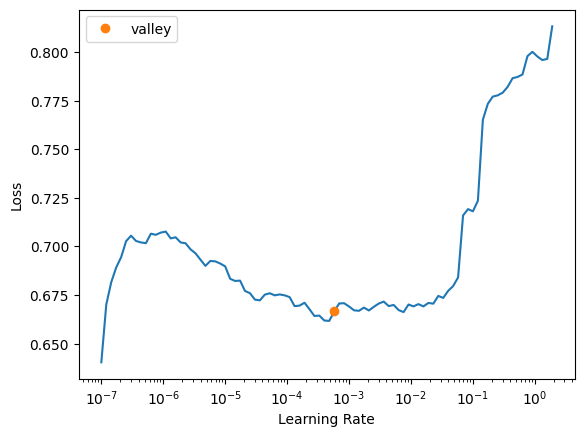

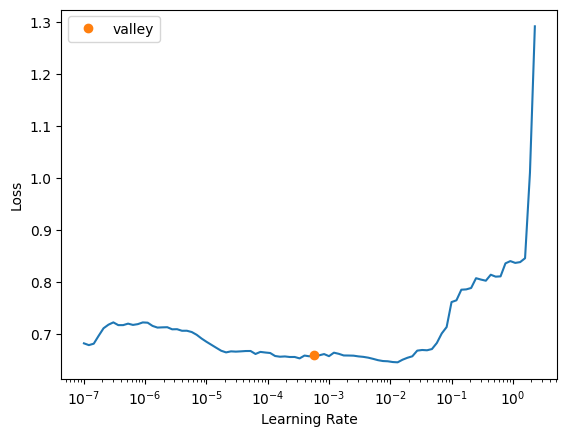

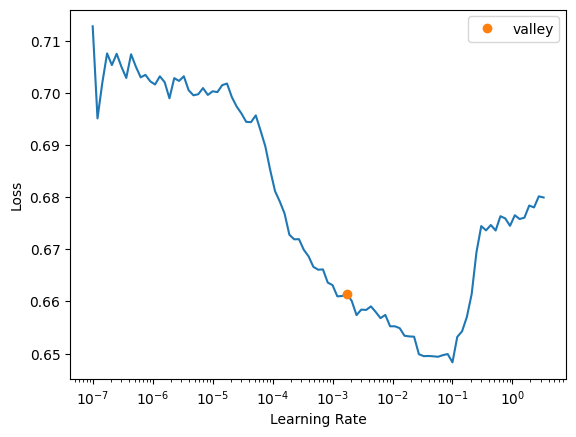

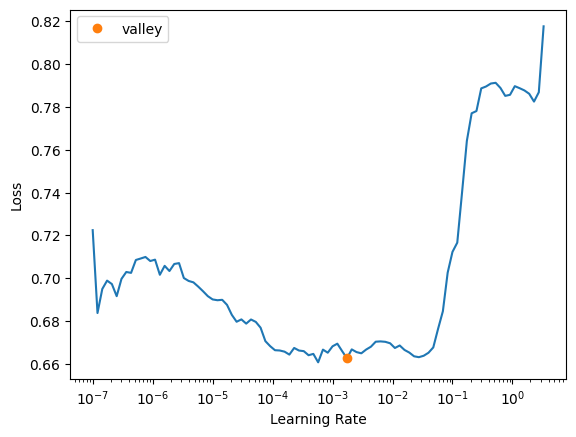

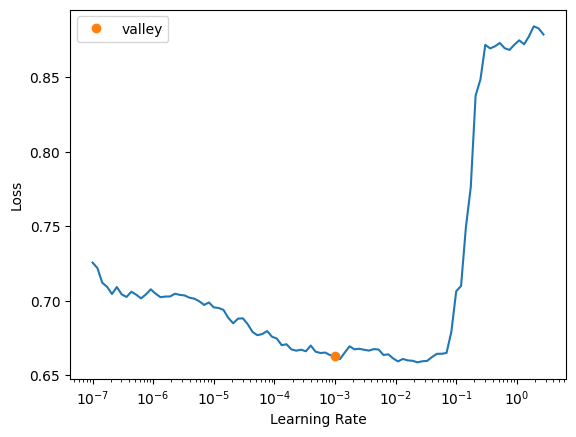

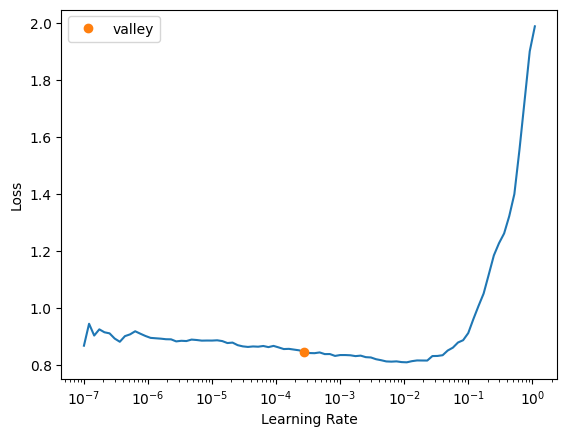

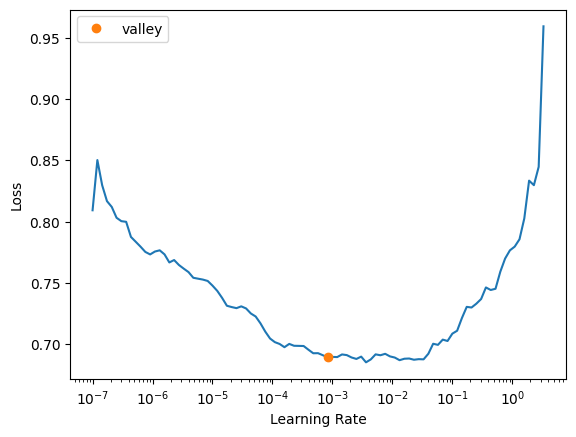

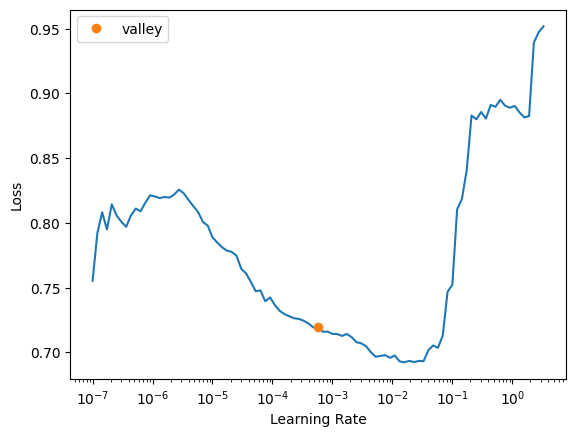

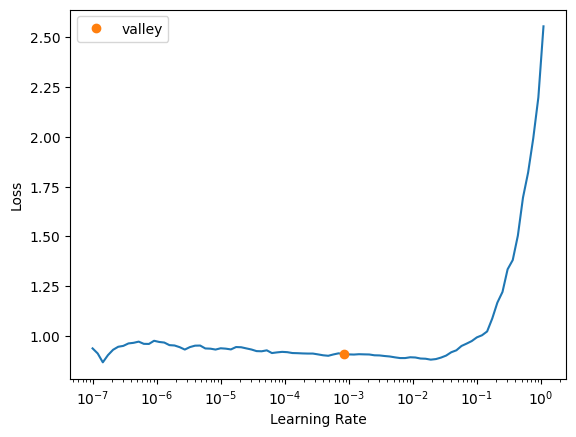

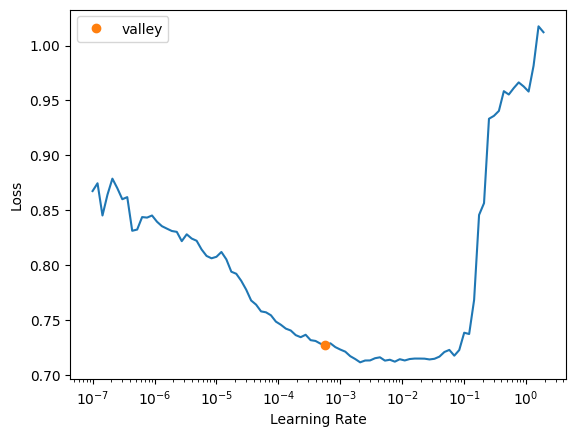

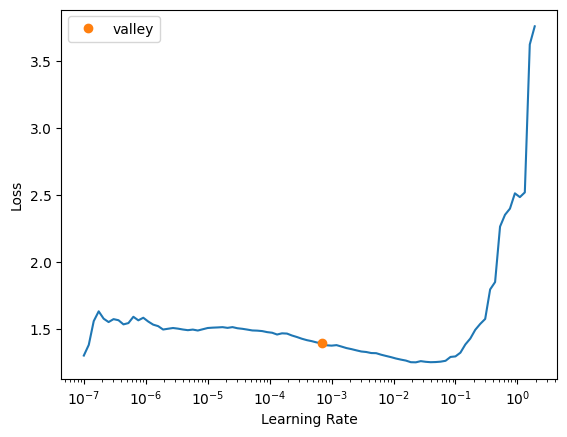

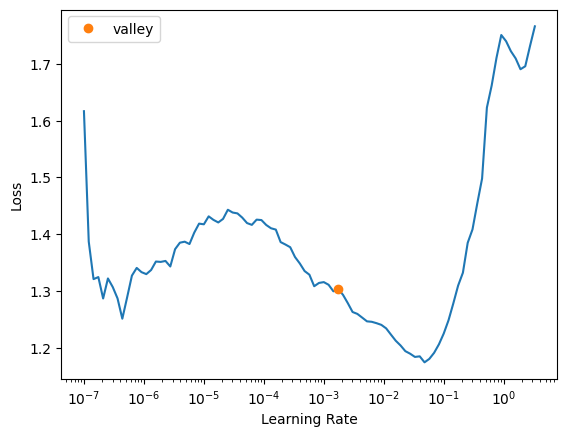

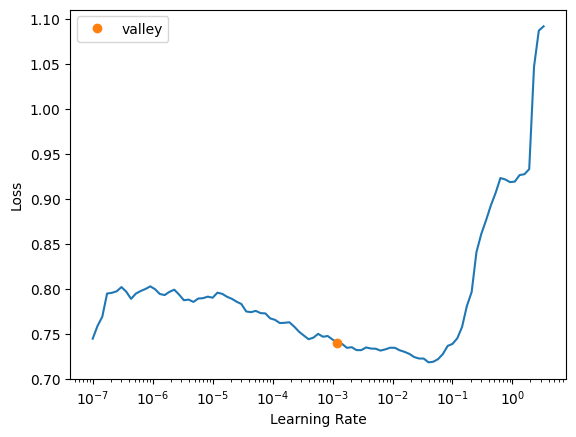

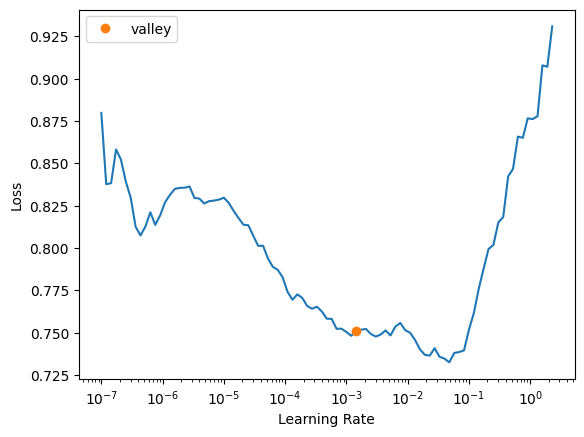

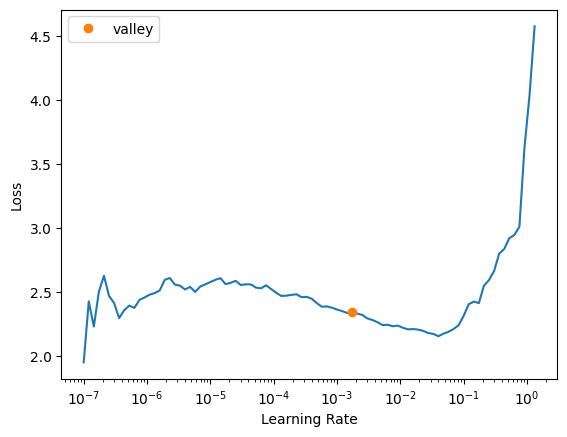

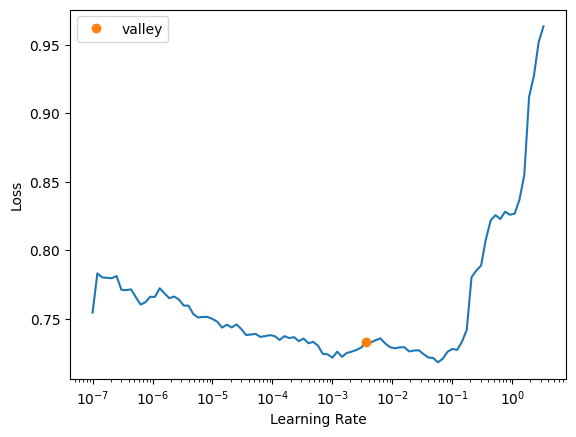

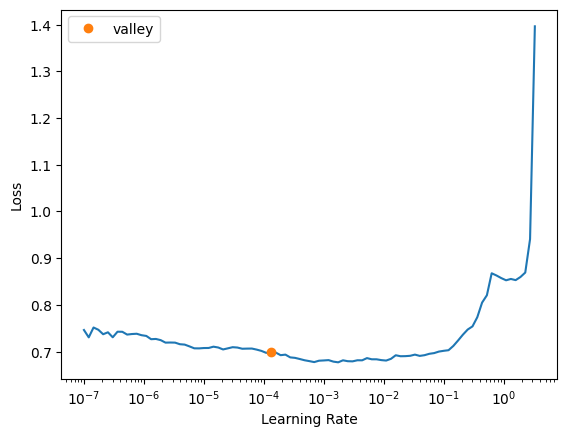

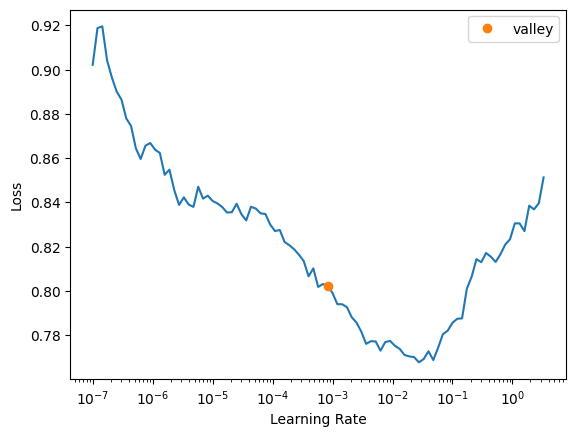

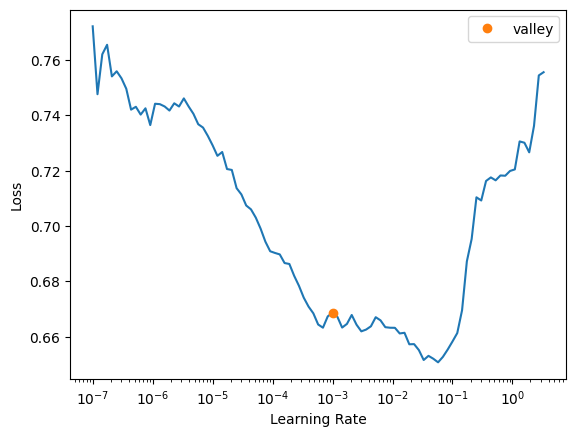

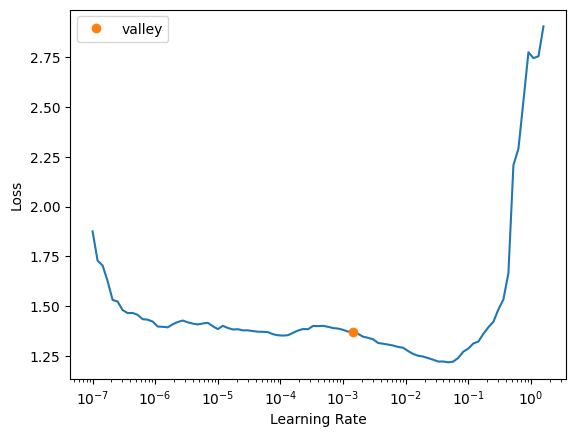

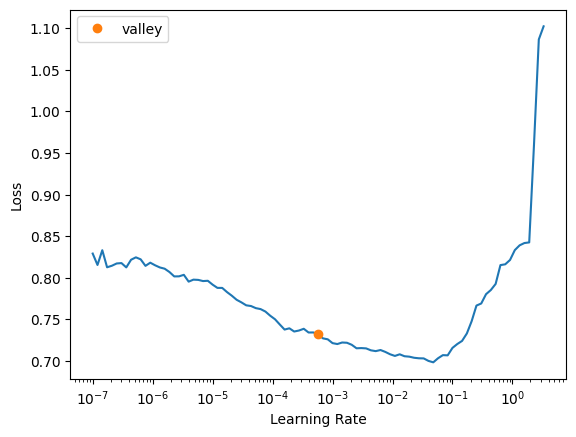

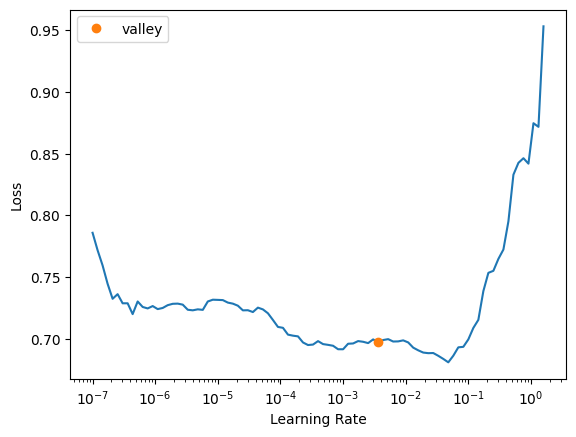

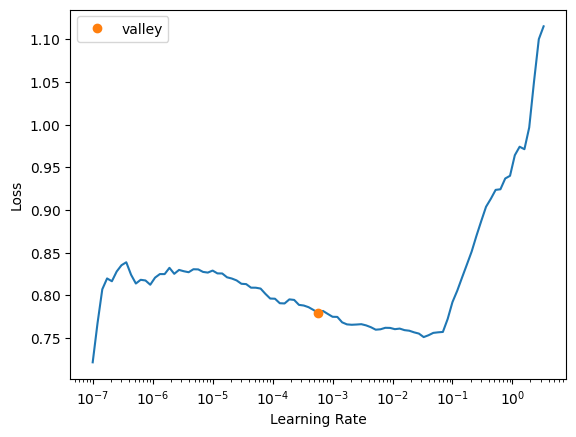

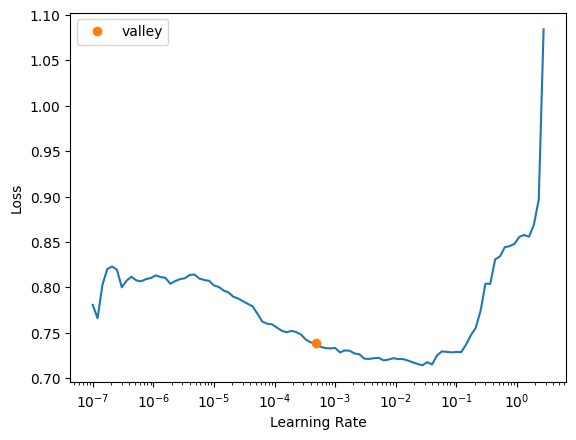

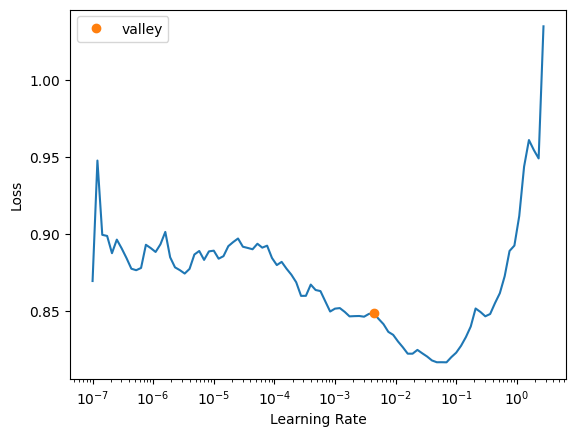

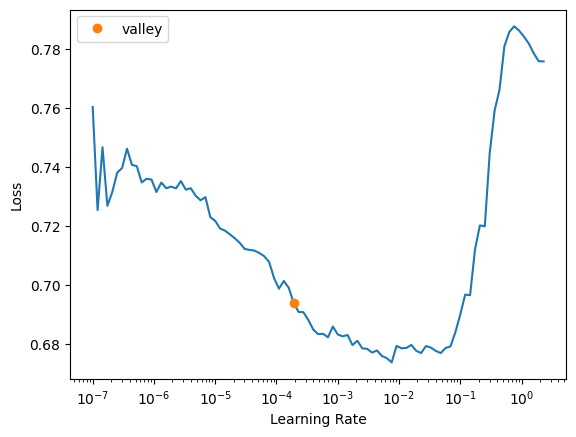

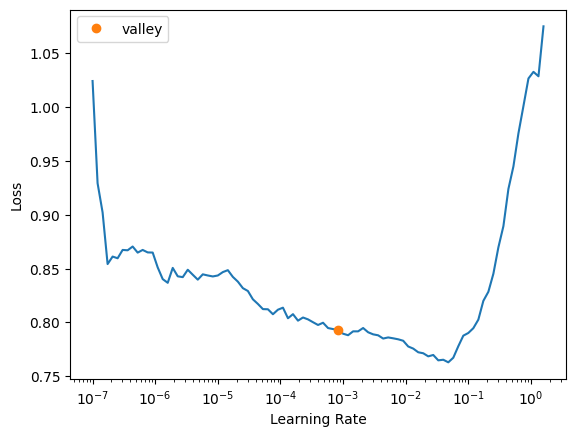

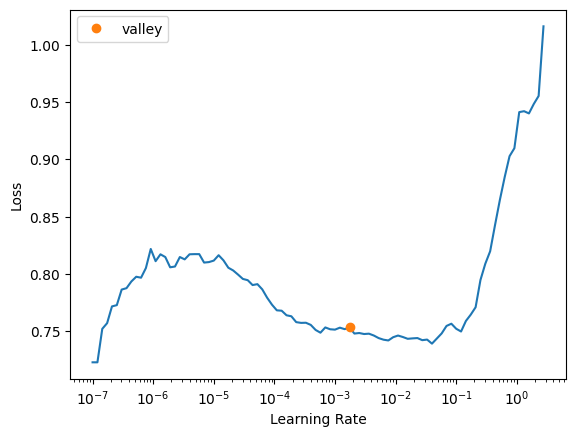

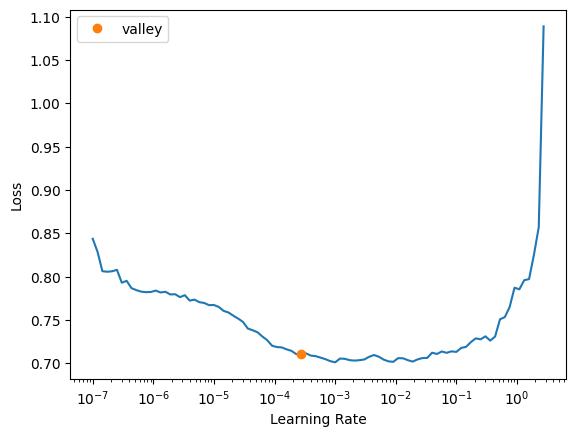

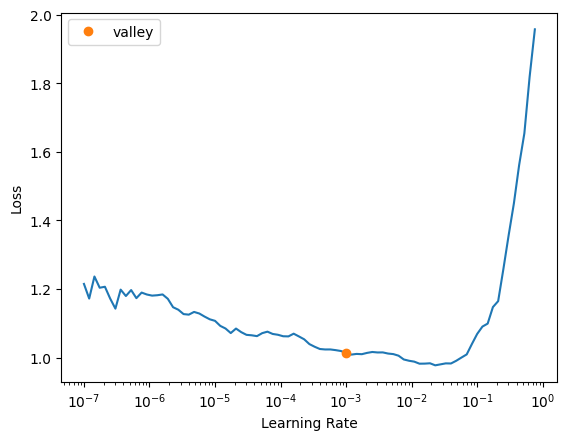

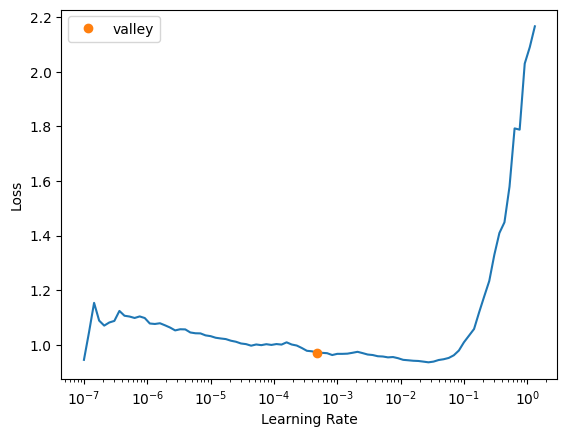

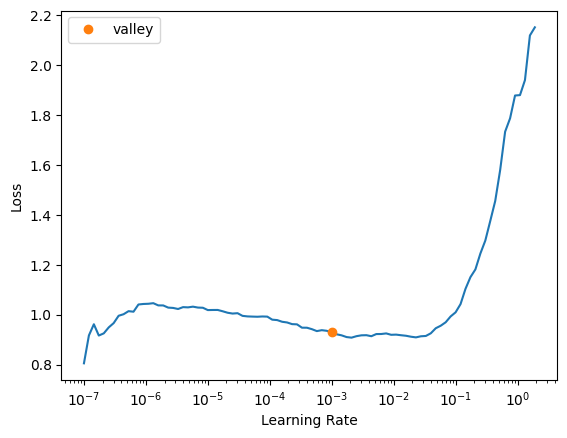

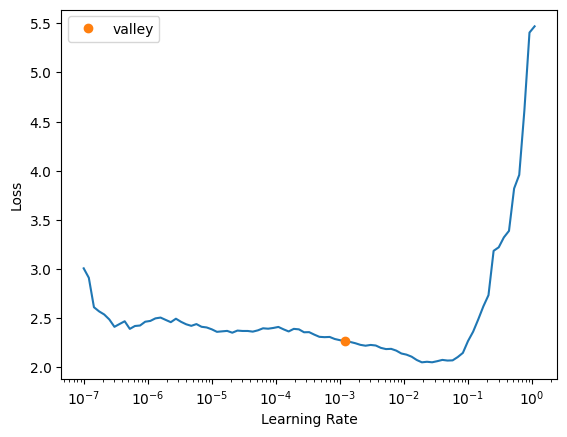

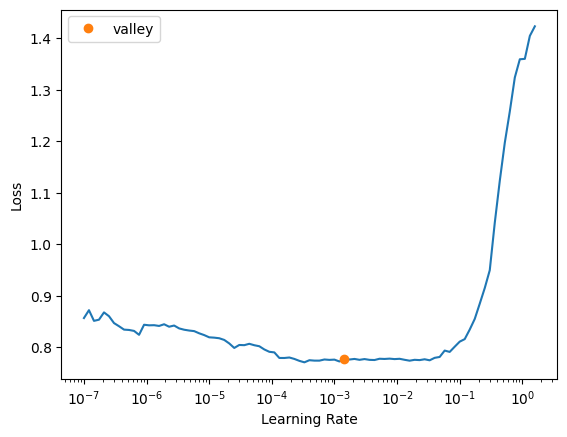

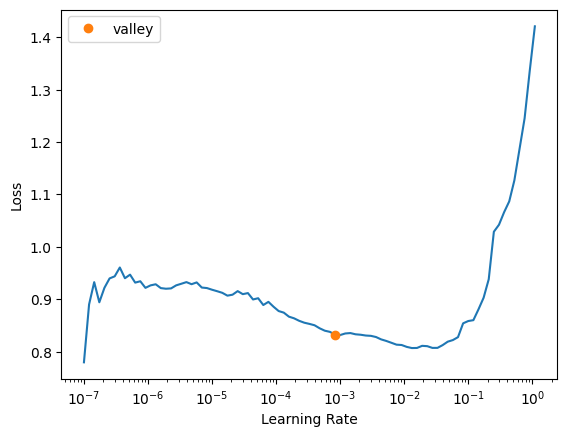

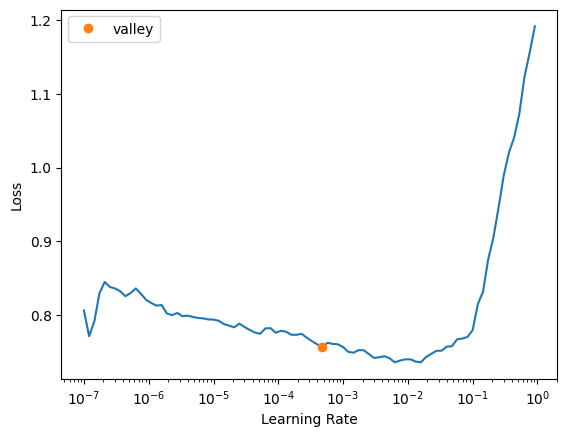

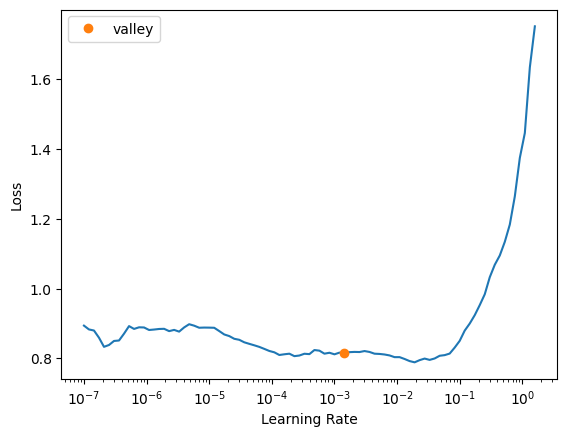

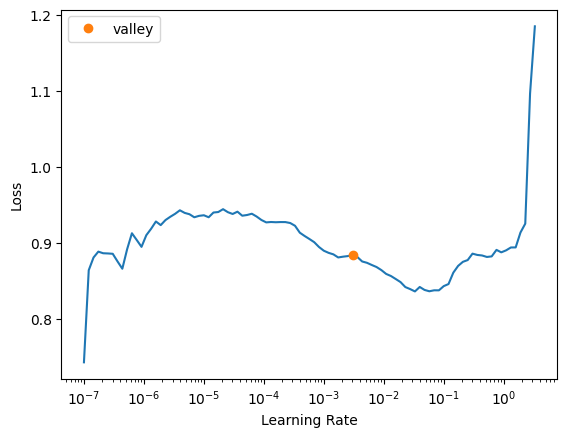

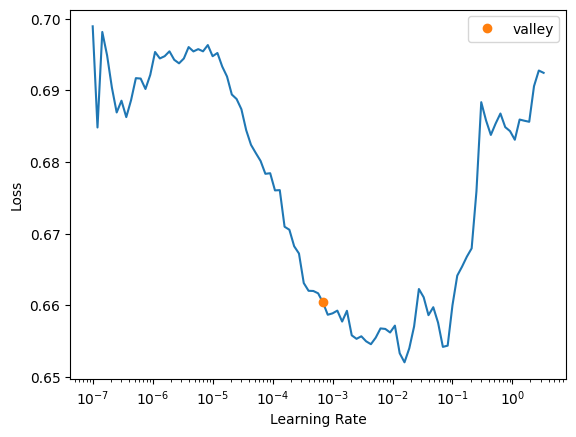

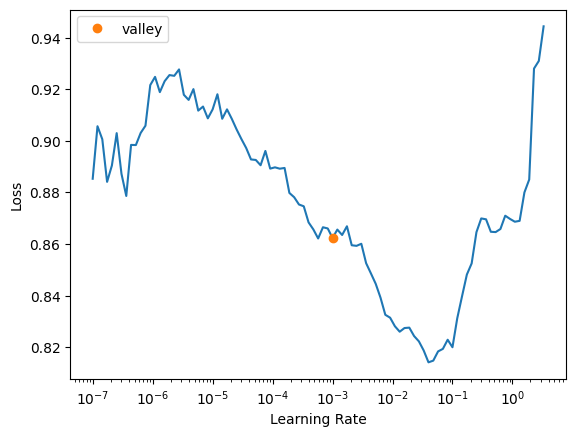

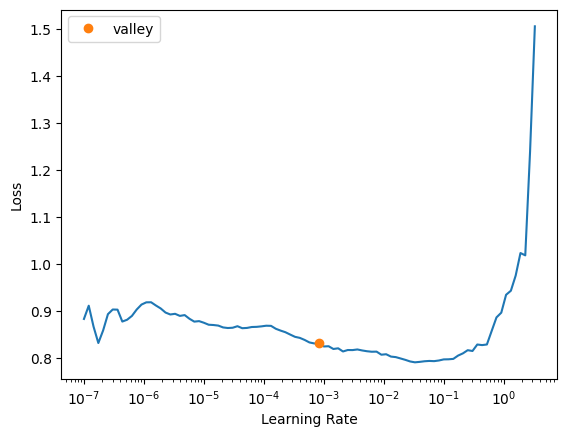

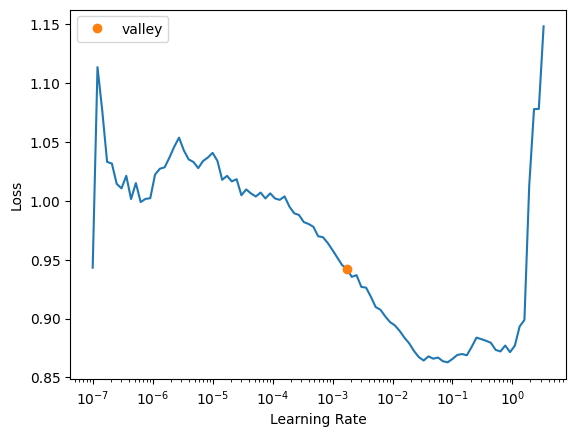

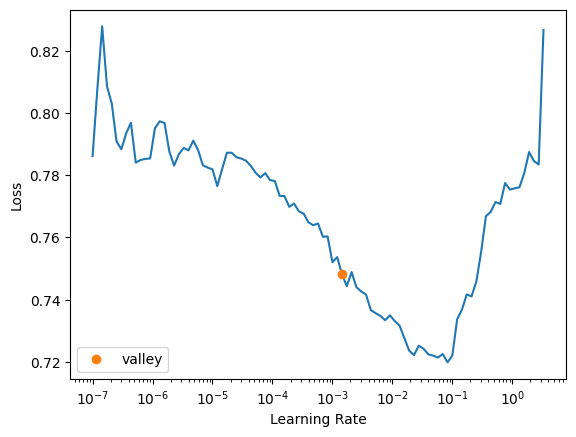

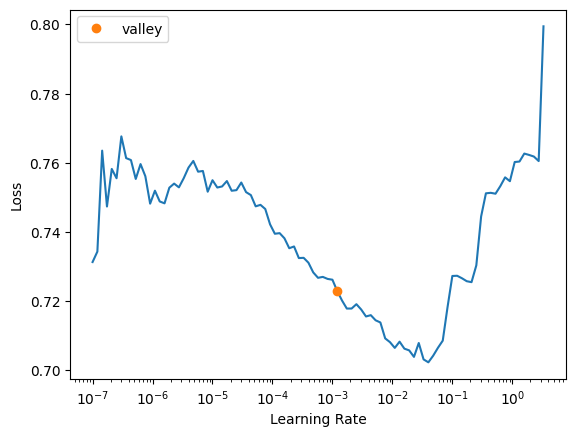

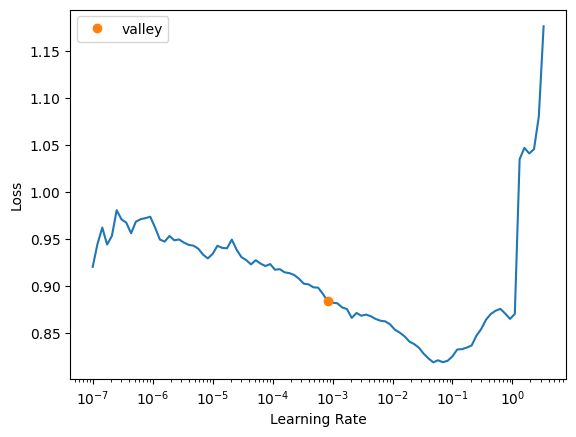

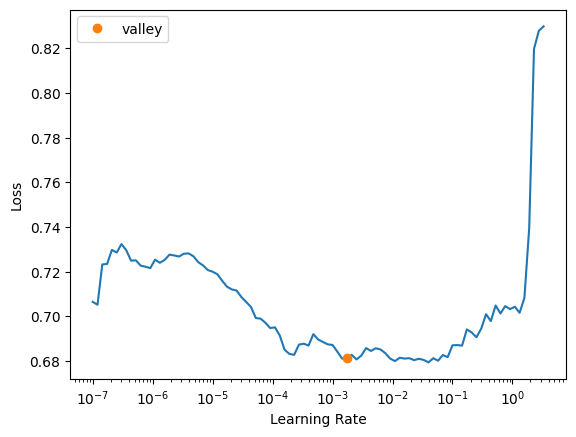

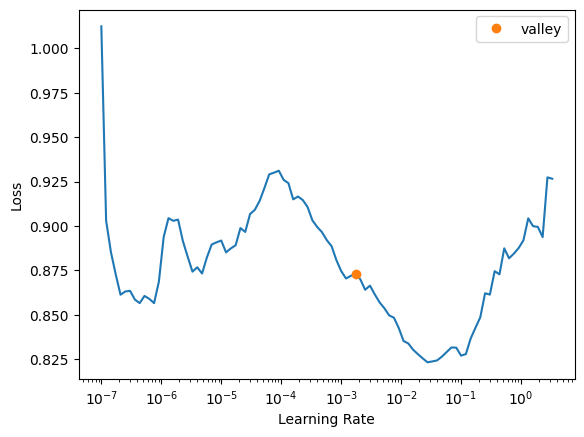

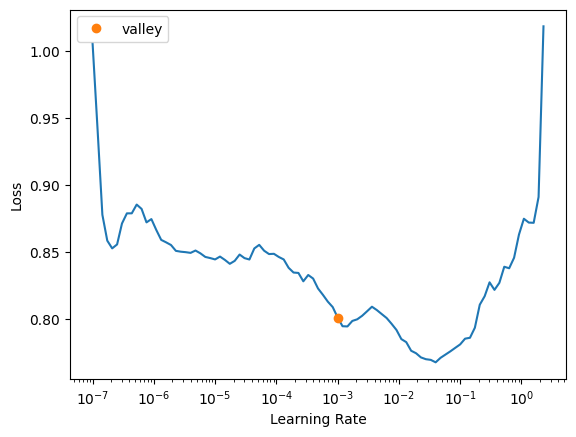

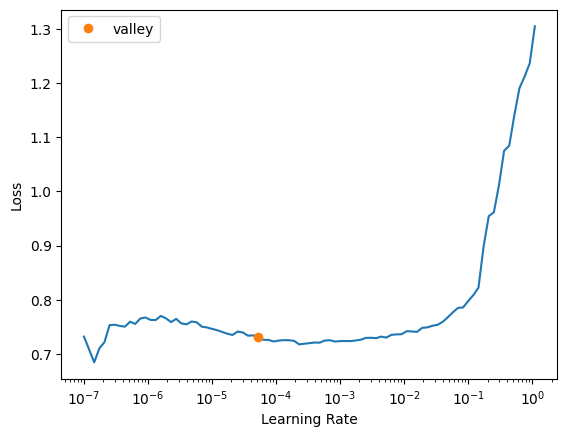

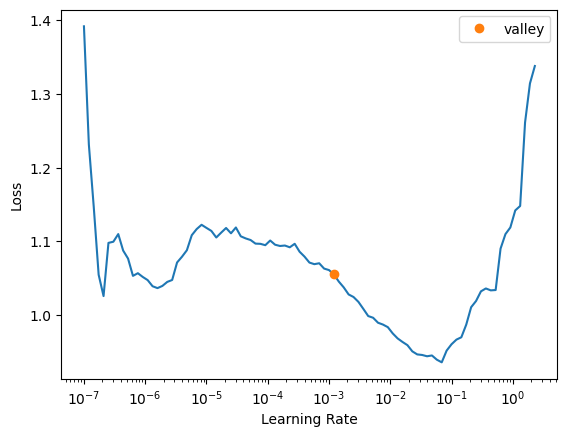

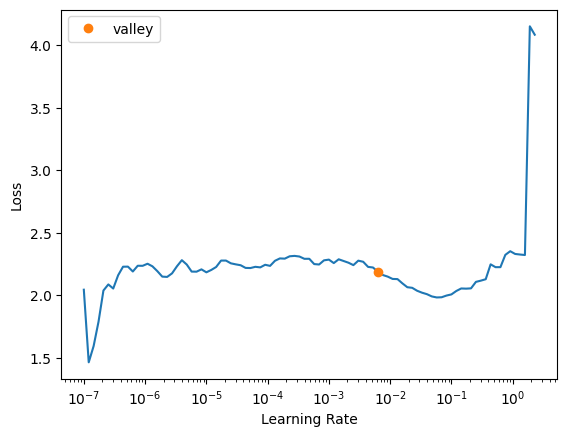

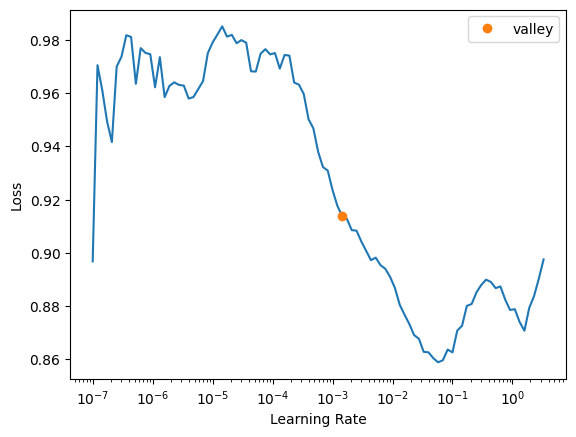

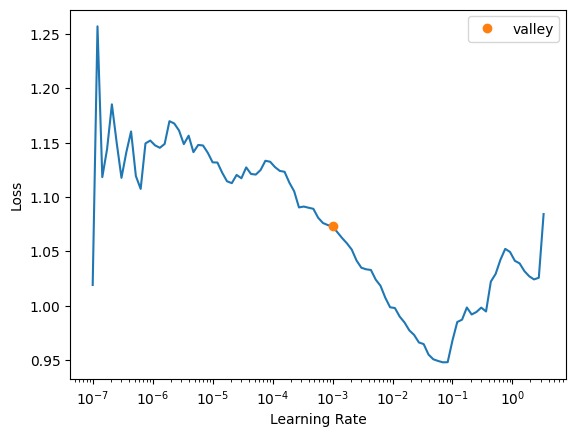

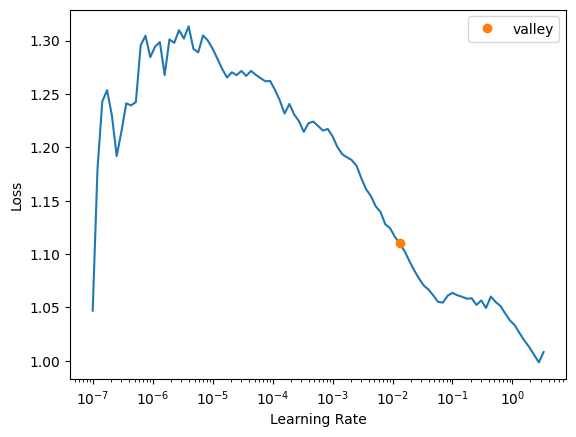

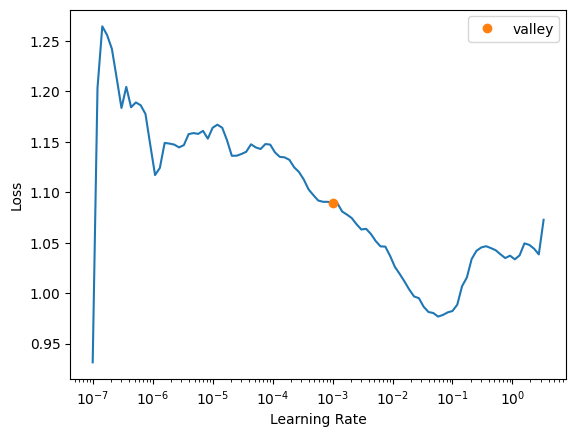

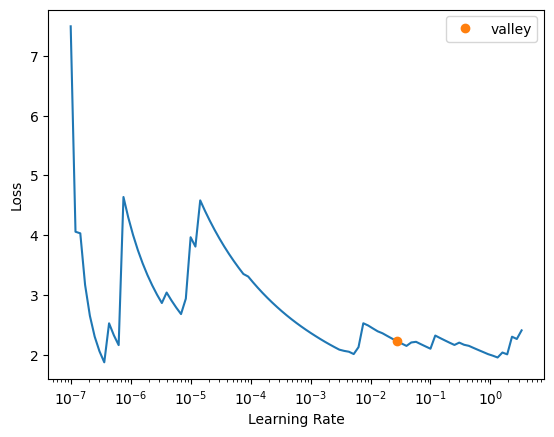

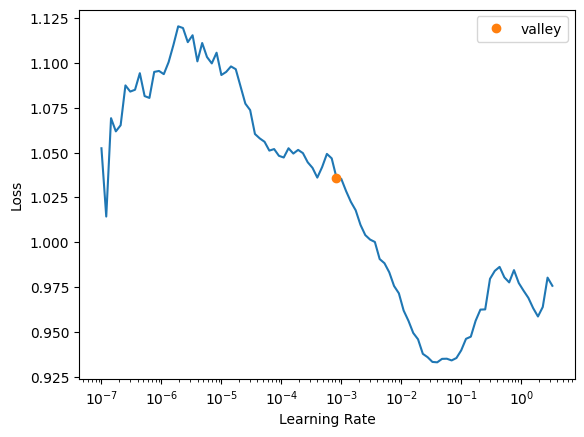

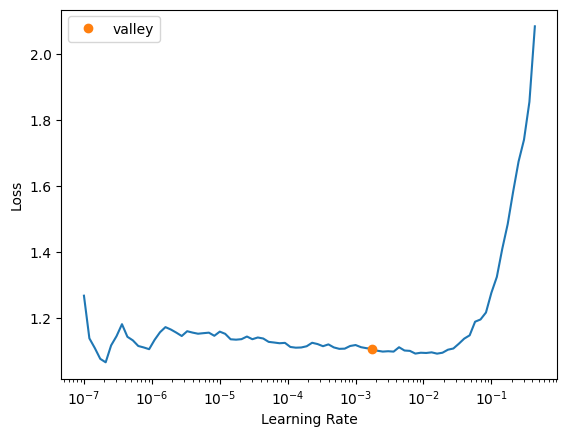

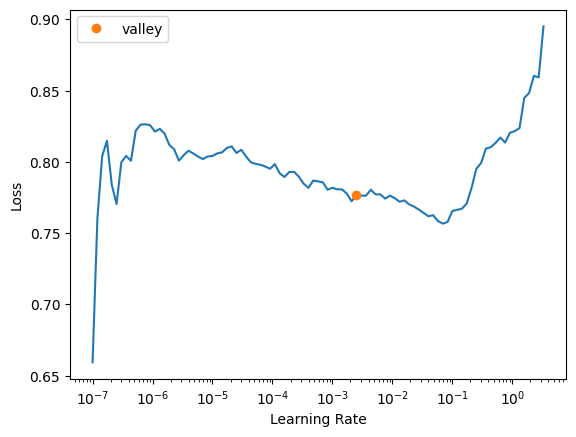

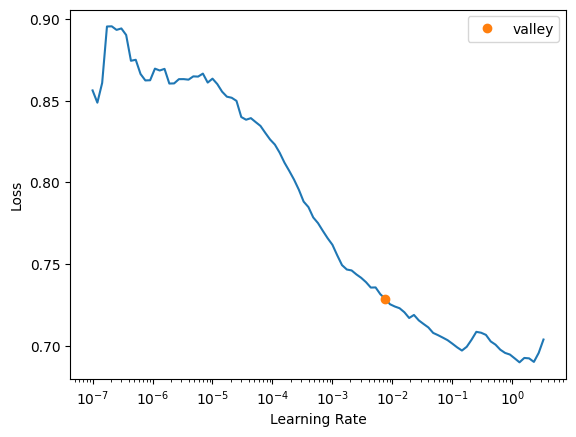

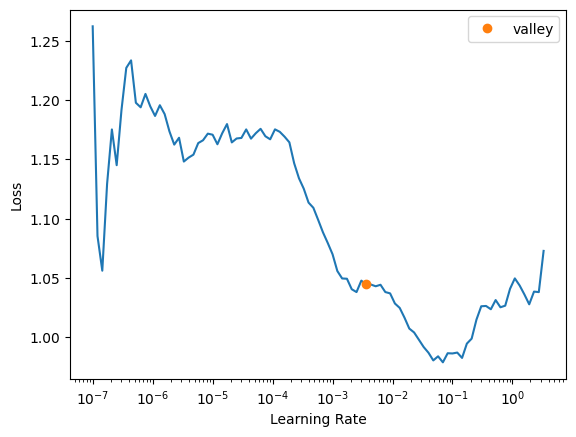

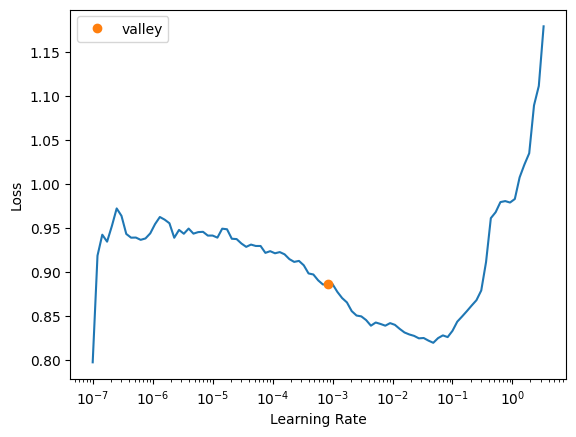

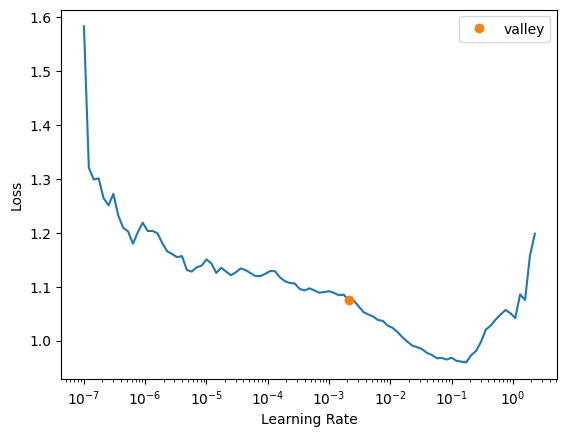

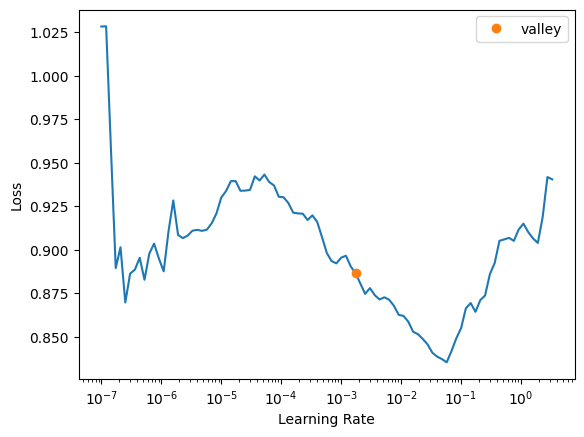

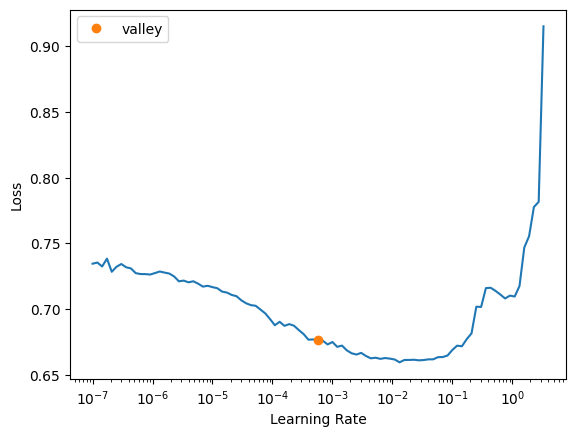

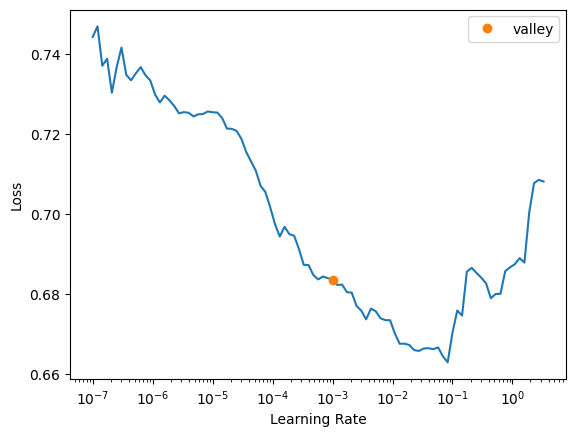

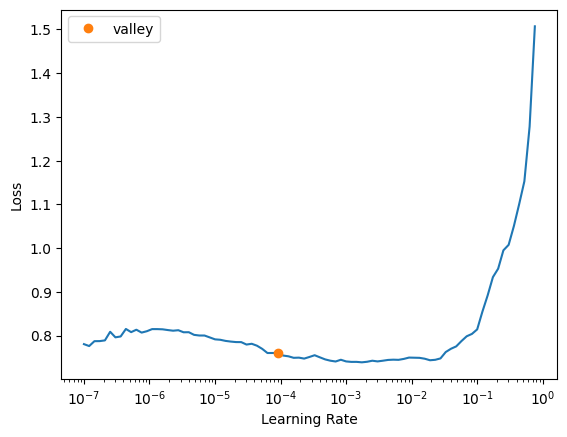

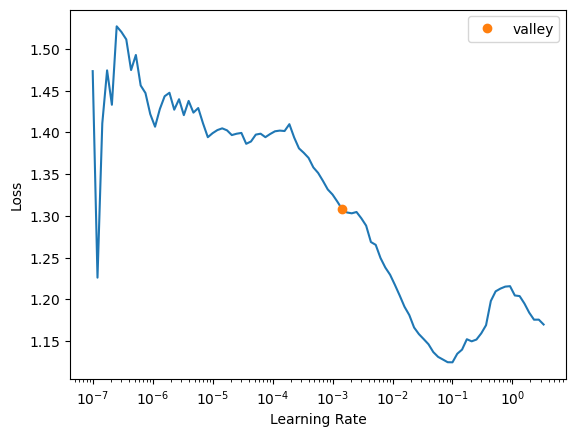

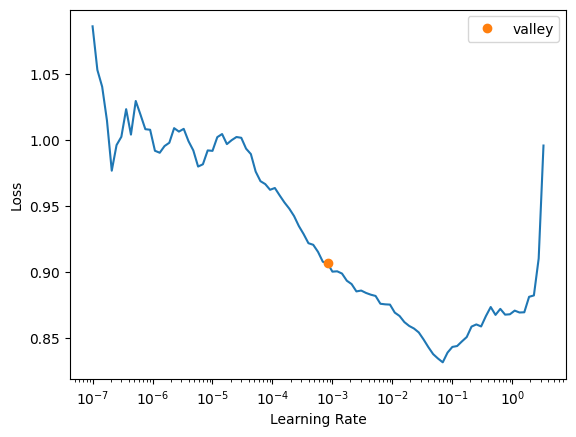

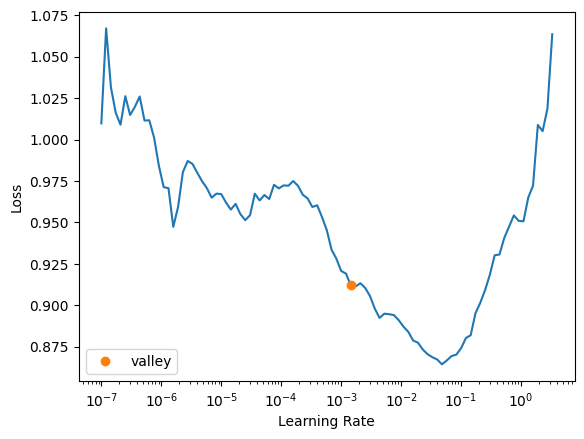

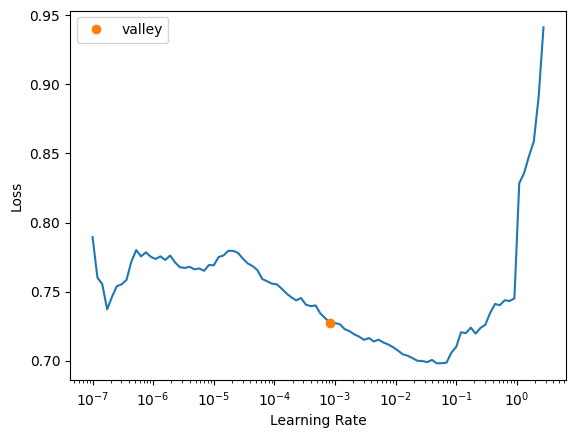

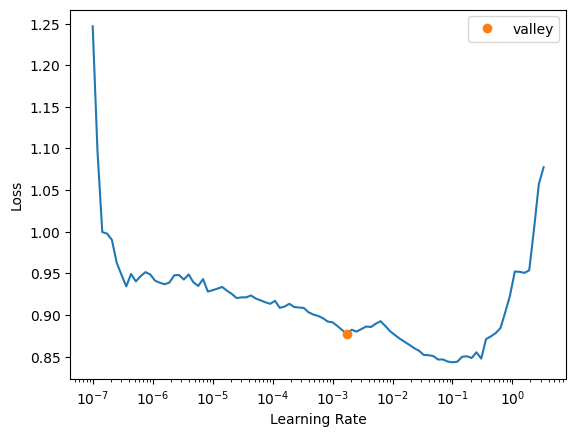

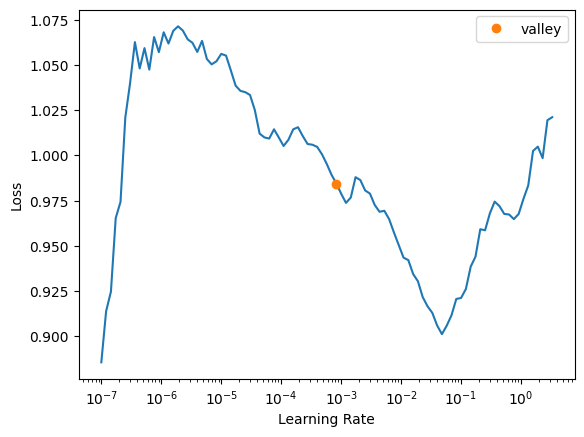

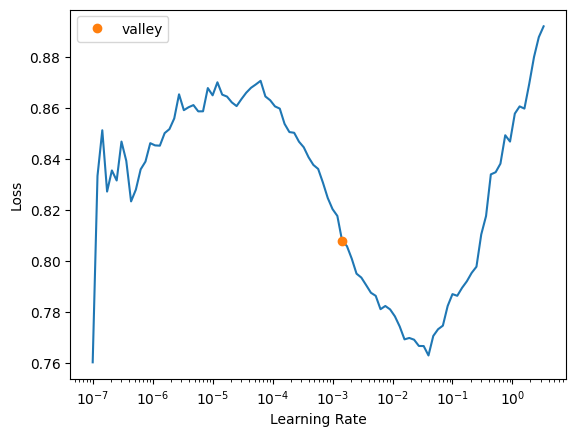

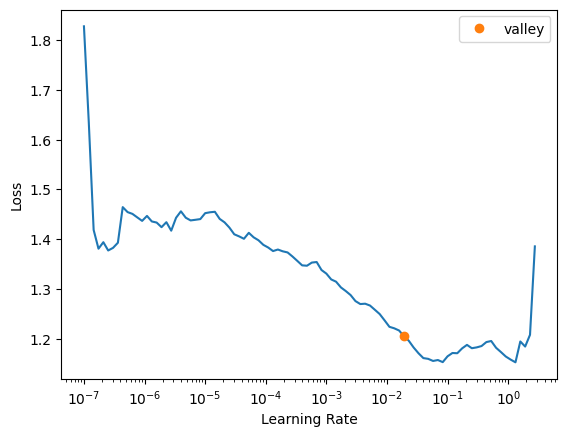

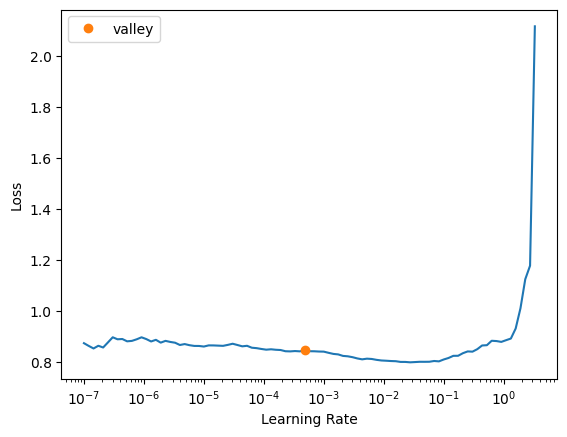

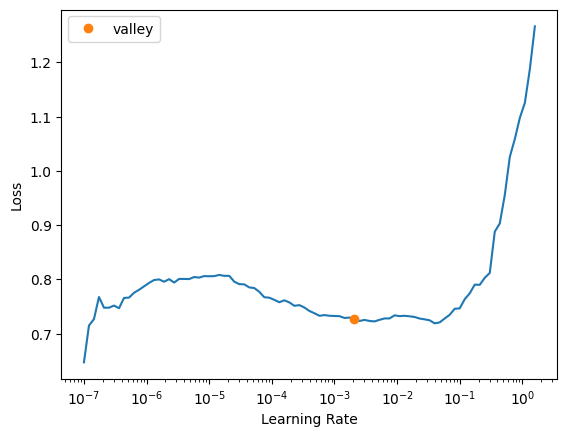

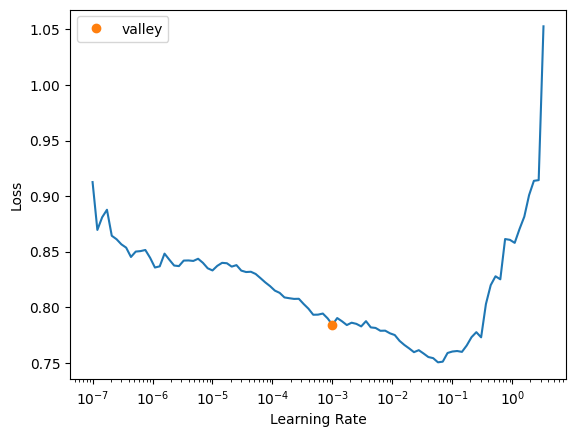

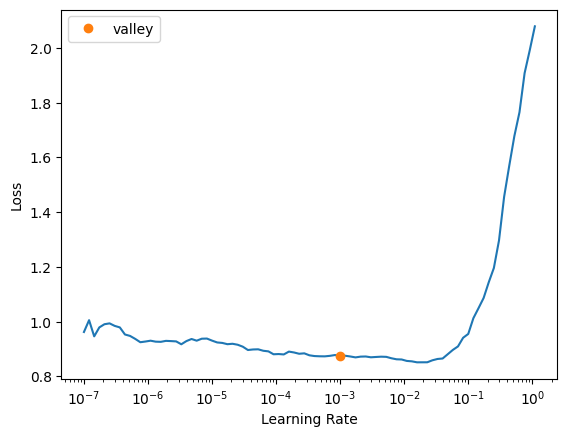

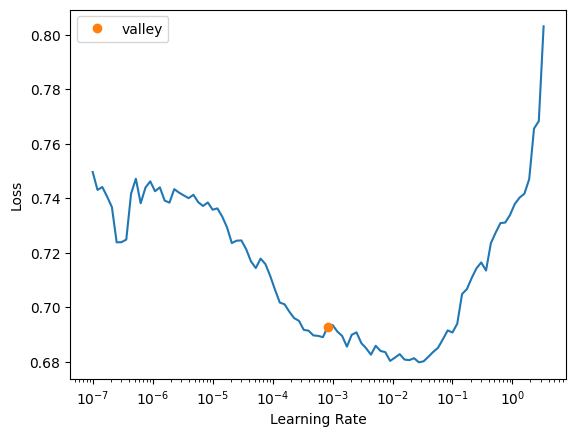

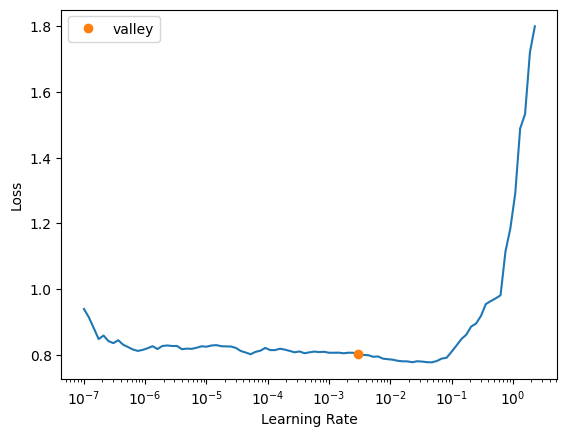

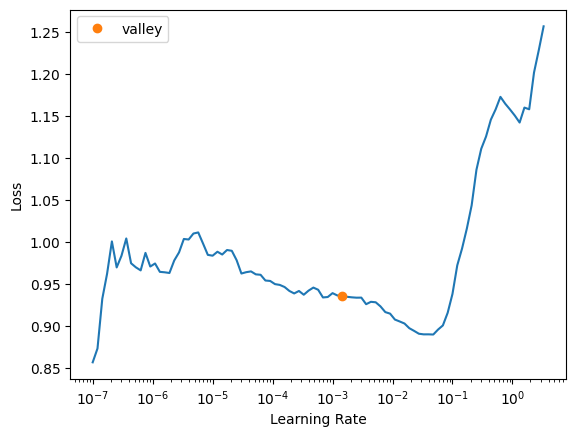

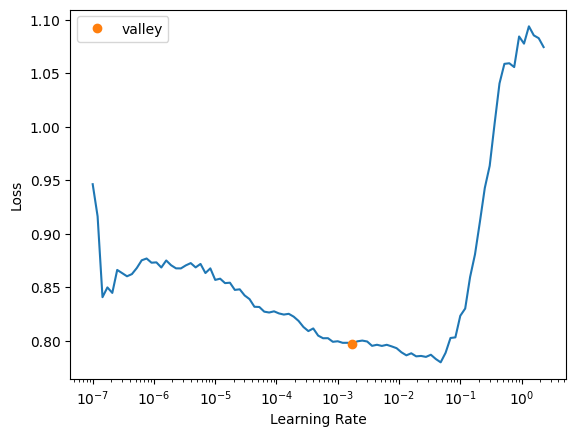

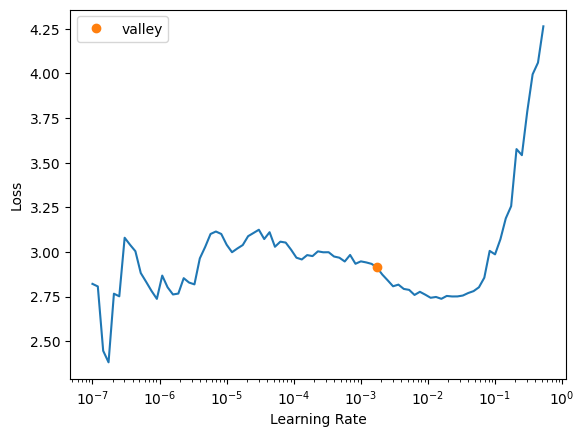

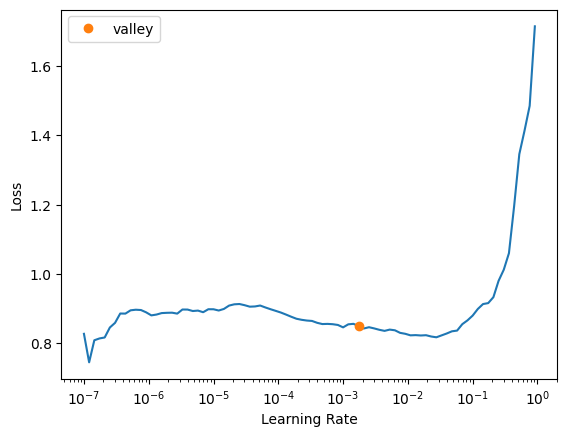

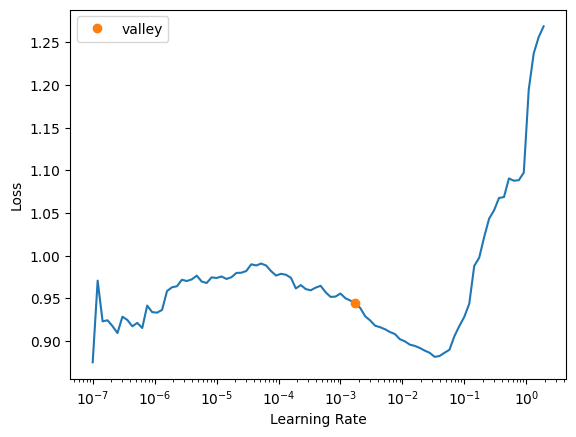

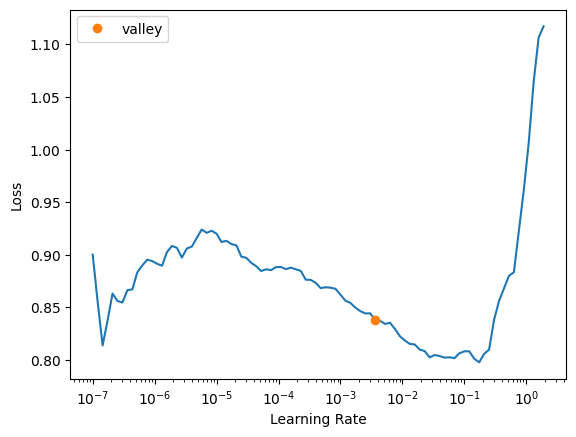

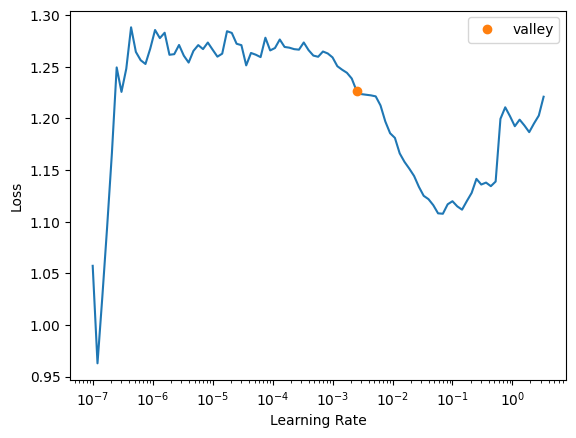

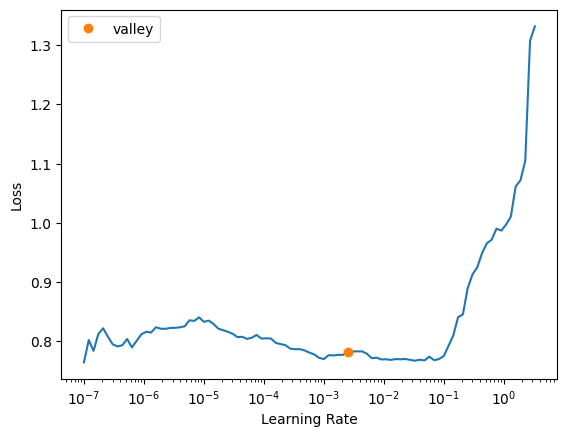

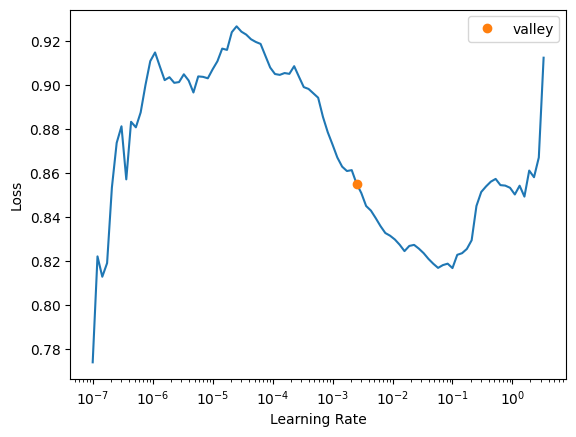

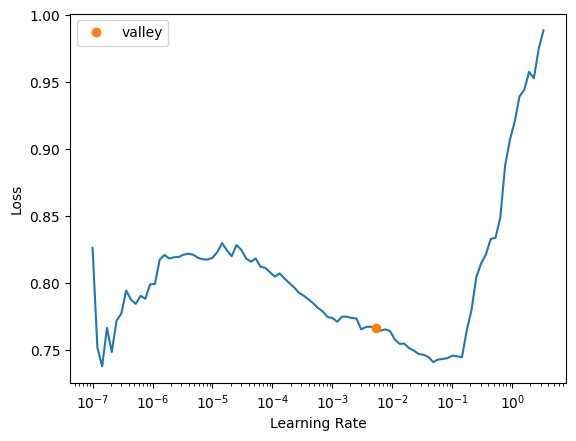

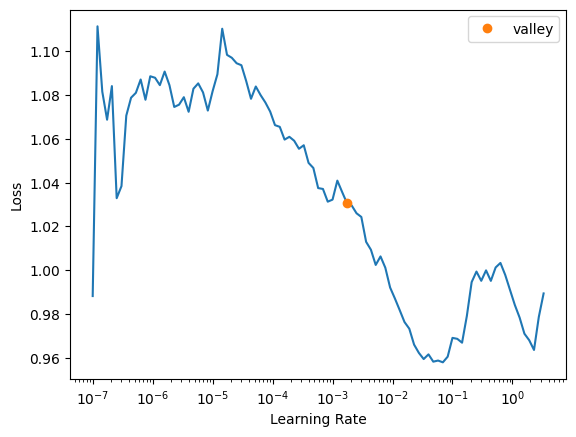

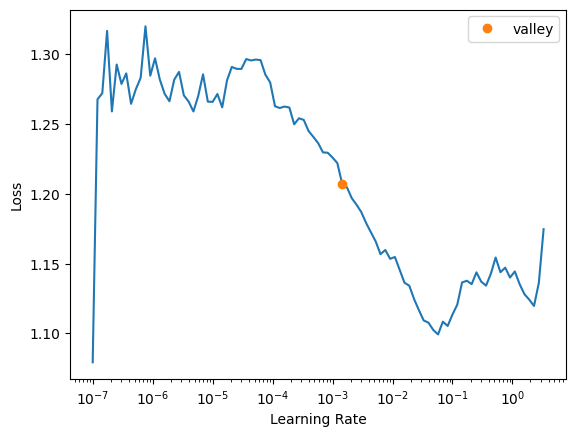

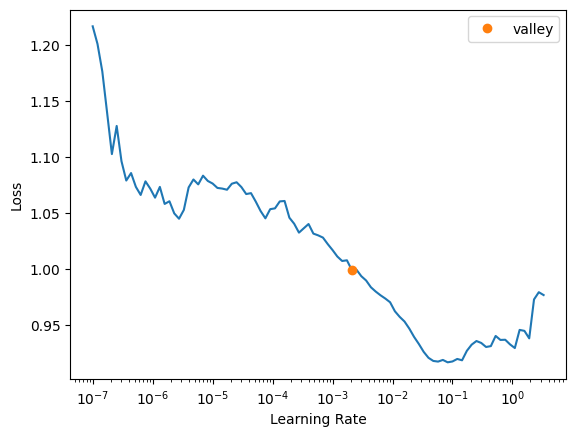

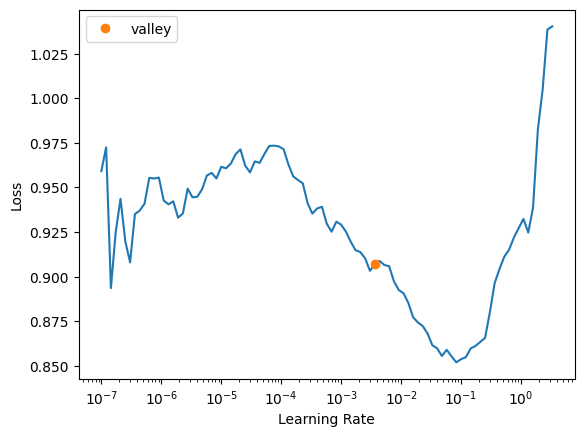

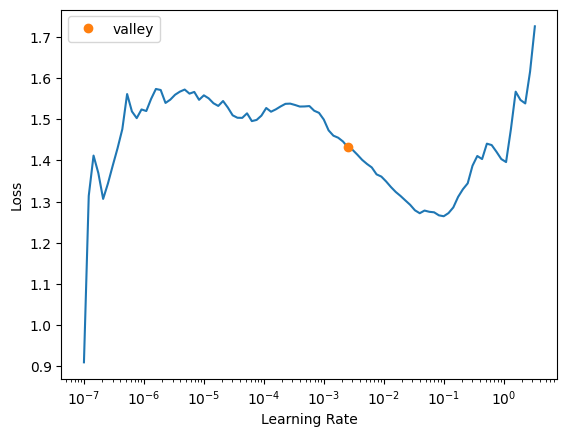

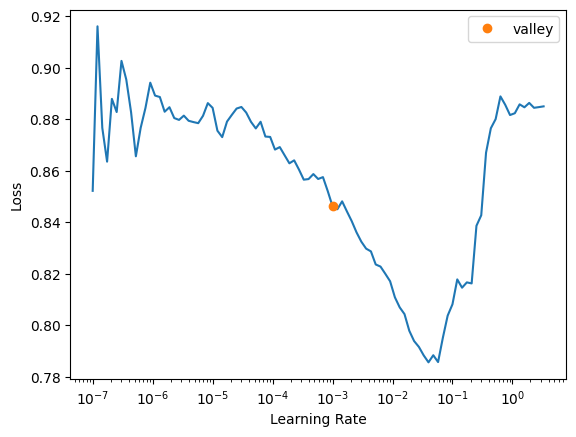

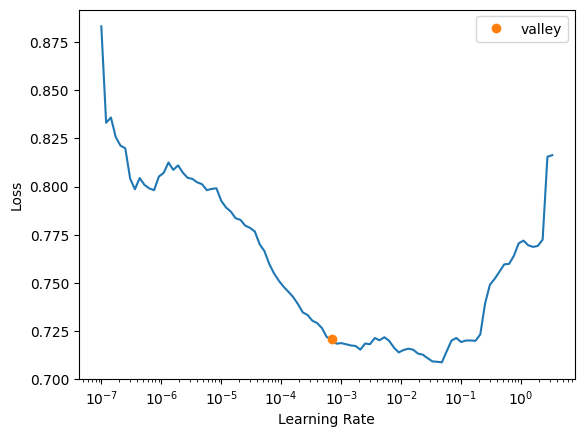

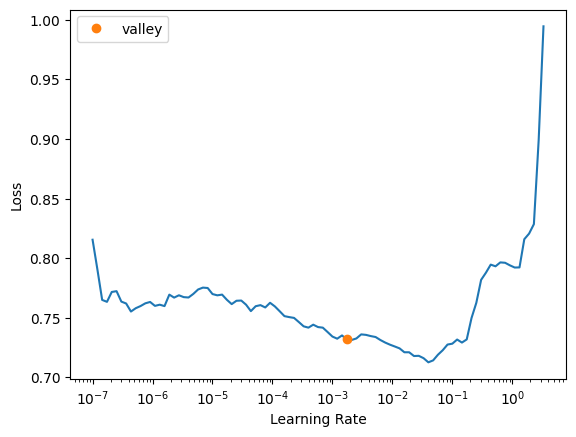

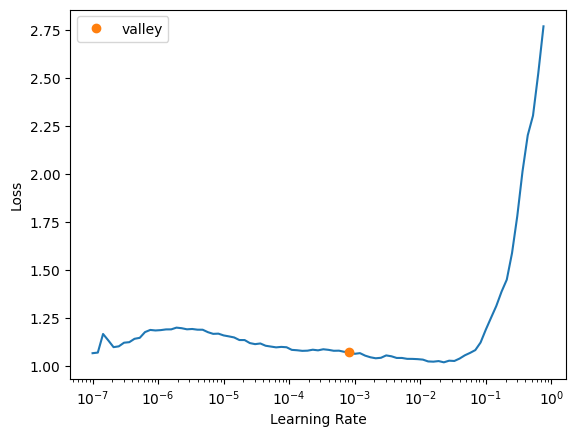

In [20]:
study = optuna.create_study(
    direction="minimize", pruner=optuna.pruners.HyperbandPruner()
)
study.optimize(objective, n_trials=num_optuna_trials, show_progress_bar=True)

In [21]:
model = TST(c_in=dls.vars, c_out=dls.c, seq_len=dls.len)
callbacks = [
    #     EarlyStoppingCallback(monitor='f1_score', comp=np.greater , patience=3),
    SaveModelCallback(
        monitor="f1_score", comp=np.greater, fname="bestmodel", every_epoch=False
    ),
    PredictionDynamics(),
]

# earlystopping = EarlyStoppingCallback(monitor='f1', comp=np.greater, patience=3)
# savemodel = SaveModel(monitor='valid_loss')
# savebestmodel = SaveModelCallback(monitor='f1_score', fname='best-model')

learn = Learner(dls, model, metrics=[accuracy, Precision(), Recall(), F1Score()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.720817,0.705476,0.496888,0.525938,0.473896,0.498563,00:54
1,0.710487,0.702817,0.503416,0.534766,0.454624,0.491449,00:54
2,0.712300,0.699858,0.497343,0.524094,0.517762,0.520909,00:54
3,0.705345,0.701674,0.500607,0.537916,0.381562,0.446445,00:54
4,0.707070,0.699734,0.504706,0.541505,0.401553,0.461145,00:53
5,0.703236,0.699657,0.510627,0.557059,0.355242,0.433828,00:53
6,0.704017,0.699972,0.513436,0.571693,0.311376,0.403166,00:54
7,0.702535,0.700100,0.513132,0.577287,0.289515,0.385632,00:54
8,0.701560,0.697634,0.514498,0.558081,0.384870,0.455567,00:54
9,0.702434,0.698972,0.513587,0.570761,0.316123,0.406886,00:54


Better model found at epoch 0 with f1_score value: 0.49856256619760936.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score
14,0.699591,0.699455,0.514422,0.583134,0.280454,0.378751


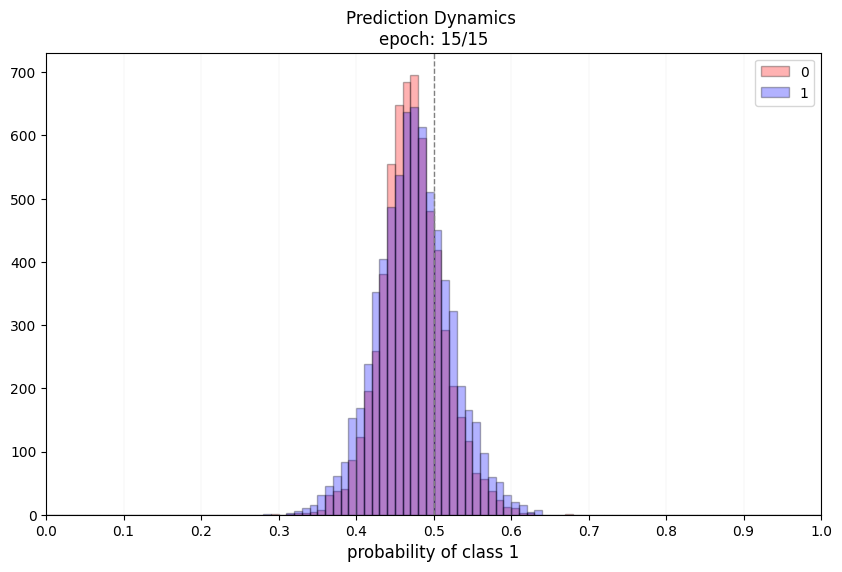

Better model found at epoch 2 with f1_score value: 0.5209086962812907.


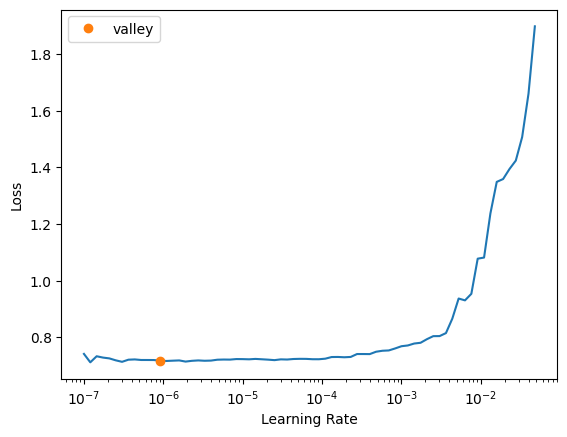

In [22]:
learn.fit_one_cycle(15, lr_max=learn.lr_find(), cbs=callbacks)

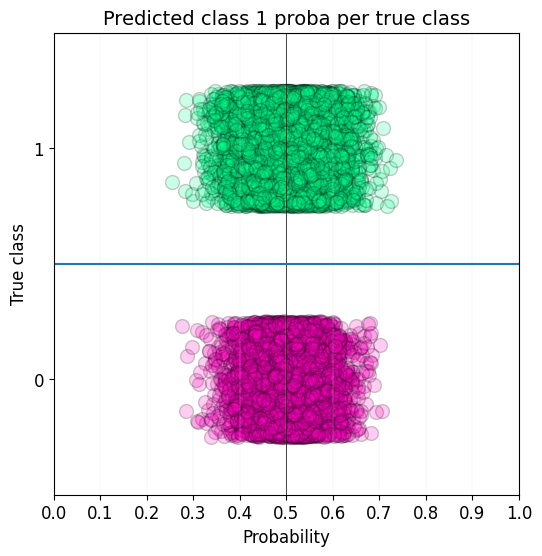

In [23]:
learn.show_probas()

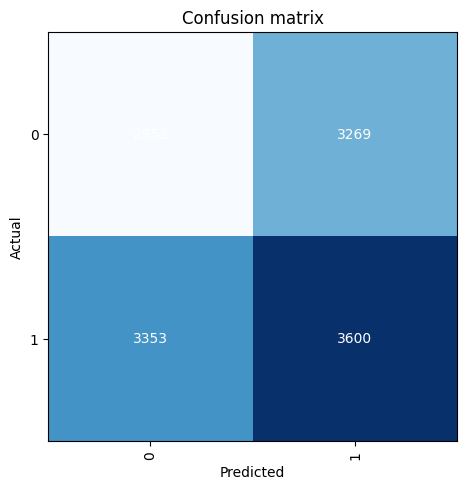

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [25]:
valid_dl = dls.valid
valid_probas, valid_targets, valid_preds = learn.get_preds(
    dl=valid_dl, with_decoded=True
)
valid_probas, valid_targets, valid_preds

(tensor([[0.5117, 0.4883],
         [0.4929, 0.5071],
         [0.4995, 0.5005],
         ...,
         [0.5238, 0.4762],
         [0.5121, 0.4879],
         [0.6080, 0.3920]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 1, 1,  ..., 0, 0, 0]))

In [26]:
positive_probs = valid_probas[:, 1]

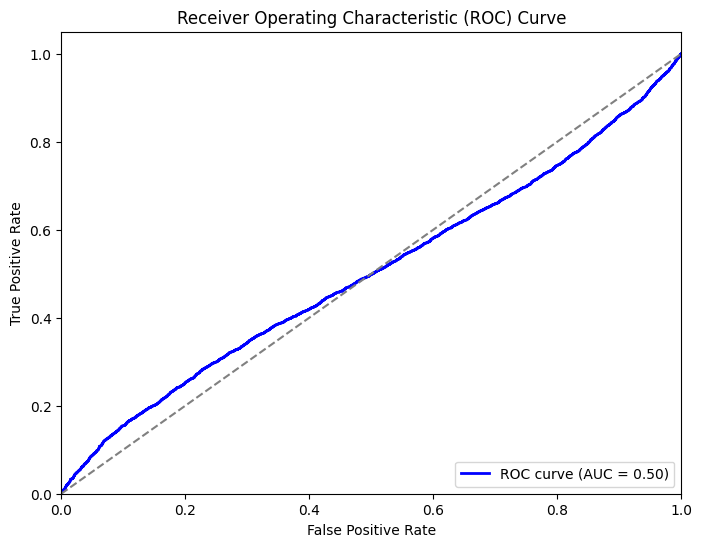

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Draw ROC curve to help us adjust the threshold to a better value.
fpr, tpr, thresholds = roc_curve(valid_targets, positive_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [28]:
# We can calculate the optimum value for the threshold from the following code:
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.5646198


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

positive_probs = valid_probas[:, 1]

threshold = optimal_threshold  ###Adjust threshold if required. Use the optimal one found in the previous cell.

valid_preds_adjusted = (positive_probs > threshold).long()

accuracy = accuracy_score(valid_targets, valid_preds_adjusted)
precision = precision_score(valid_targets, valid_preds_adjusted)
recall = recall_score(valid_targets, valid_preds_adjusted)
f1 = f1_score(valid_targets, valid_preds_adjusted)

print("Adjusted Threshold Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Adjusted Threshold Metrics:
Accuracy: 0.5082
Precision: 0.6287
Recall: 0.1665
F1 Score: 0.2633


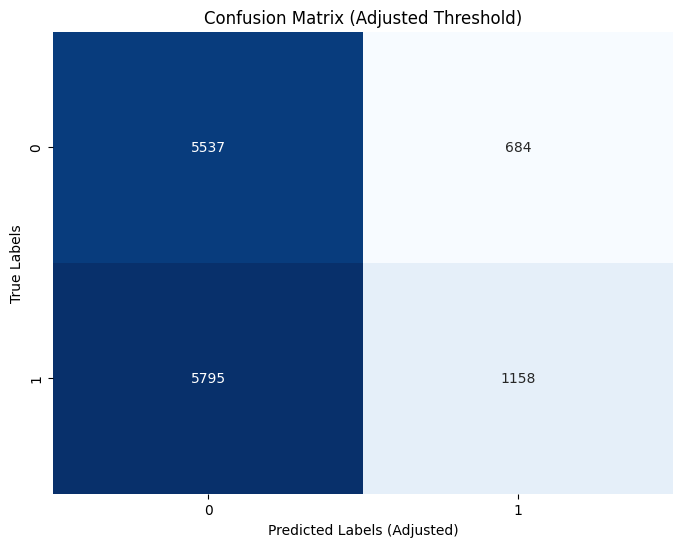

In [30]:
# Plot confusion matrix after adjsuting the threshold
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(valid_targets, valid_preds_adjusted)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels (Adjusted)")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.show()

Hyperparameter optimization.
https://github.com/timeseriesAI/tsai/discussions/138

Task 2 - Define the hyperparameters of the model, and do an optimzation study on them.

In [32]:
f"{learn.smooth_loss.item():.4f}"

'0.6996'

In [33]:
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
Best trial:
  Value:  0.5324450731277466
  Params: 
    num_filters: 32
    dropout_rate: 0.9586032172412705
